# **Prophet**

In [1]:
import itertools, warnings, os, subprocess
from pathlib import Path
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from dateutil.easter import easter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot

plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly.graph_objs as go

In [2]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()

def download_data(dataset, path):
    # Create local folder if one doesn't exist
    os.makedirs(path, exist_ok=True)
    # Call Kaggle API
    kaggle_call = f"kaggle datasets download -d {dataset} -p {path} --unzip"
    subprocess.run(kaggle_call, shell=True, check=True)
    print(f"Dataset '{dataset}' has been downloaded to '{path}'")

# Download additional datasets from Konrad's NB
dataset = "niclowe/who-cases-dataset-and-wdi-country-population"
download_path = "data/who-data"

download_data(dataset, download_path)

Dataset URL: https://www.kaggle.com/datasets/niclowe/who-cases-dataset-and-wdi-country-population
License(s): unknown


  0%|          | 0.00/107k [00:00<?, ?B/s]


Dataset 'niclowe/who-cases-dataset-and-wdi-country-population' has been downloaded to 'data/who-data'


100%|██████████| 107k/107k [00:00<00:00, 183kB/s]


In [3]:
data = 'data/'

class CFG:
    img_dim1 = 10
    img_dim2 = 8

# Set Param for visualizations
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2),
                     'font.size': 10})

## A Primer on Generalized Additive Models (GAM)

In previous NBs, we covered exponential smoothing which is pretty useful as a first-pass modelling approach but is seriously hampered since it only handles one seasonal pattern at a time. This led to the development of Prophet at Facebook, which is based on the concept of structural decomposition.

$$
X_t = T_t + S_t + H_t + \epsilon_t
$$

where:
- $T_t$        is the observed time series at time.
- $S_t$        is the seasonal component (which can be weekly, yearly or custom)
- $H_T$        is the deterministic irregular component (holidays, discontinuities etc.)
- $\epsilon_t$ is the noise

The Kolmogorov-Arnold representation theorem states that multivariate functions could be represented as sums and compositions of univariate functions. The simplified general representation is as follows:

$$ \Phi^{-1}[\mathbb{E}(Y)] = \beta_0 + f_1(x_1) + f_2(x_2) + \cdots + f_m(x_m) $$

The GAM decomposition is used as the starting point for Prophet. We will now look at the implementations of two trend models next.

## Trend Model

### Linear Trend

The default trend model is a:

> Piecewise Linear Model with a constant rate of growth. It is best suited for problems without saturating growth and takes advantage of the fact that a broad class of shapes can be approximated by a piecewise linear function.

> By default, Prophet estimates 25 changepoints in the model, over 80pct of the dataset (those parameters can be adjusted). Changepoints are defined as changes in the trajectory, which can be esimated or provided manually - the latter is a useful option if domain knowledge is available to the analyst.

In [4]:
# Using the New York Times data on Covid cases for demo purposes
df = pd.read_csv(data + 'us_covid.csv')
df.head(10)

date  cases  deaths
0  2020-01-21      1       0
1  2020-01-22      1       0
2  2020-01-23      1       0
3  2020-01-24      2       0
4  2020-01-25      3       0
5  2020-01-26      5       0
6  2020-01-27      5       0
7  2020-01-28      5       0
8  2020-01-29      5       0
9  2020-01-30      6       0

In [5]:
df.describe().round(2)

cases     deaths
count       594.00     594.00
mean   16034557.83  308550.07
std    13906317.76  224858.33
min           1.00       0.00
25%     2184128.75  117927.75
50%    10728694.00  243560.00
75%    31147891.50  561082.00
max    40005266.00  648273.00

The most _annoying_ feature in Prophet - by far - is the usage of a hardcoded format for inputs. This **must** be a date column named `ds` which can either be an index or column. A column `y` stores the actual values of the time series.

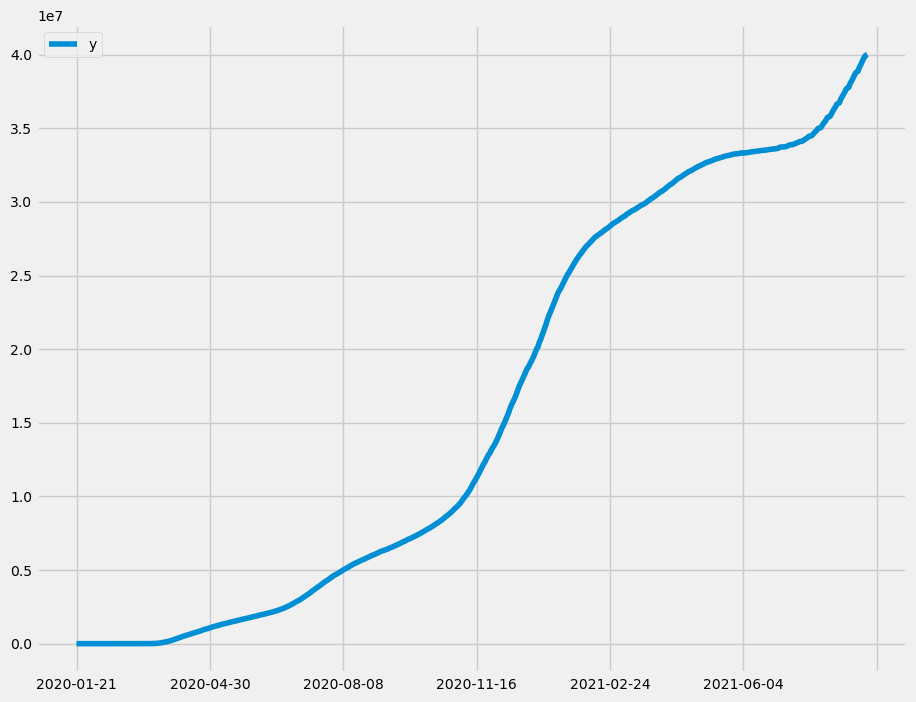

In [6]:
# Renaming cols and plotting the time series
xdat = df[['date', 'cases']].rename(columns={"date": "ds", "cases": "y"})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='');

11:16:23 - cmdstanpy - INFO - Chain [1] start processing
11:16:23 - cmdstanpy - INFO - Chain [1] done processing


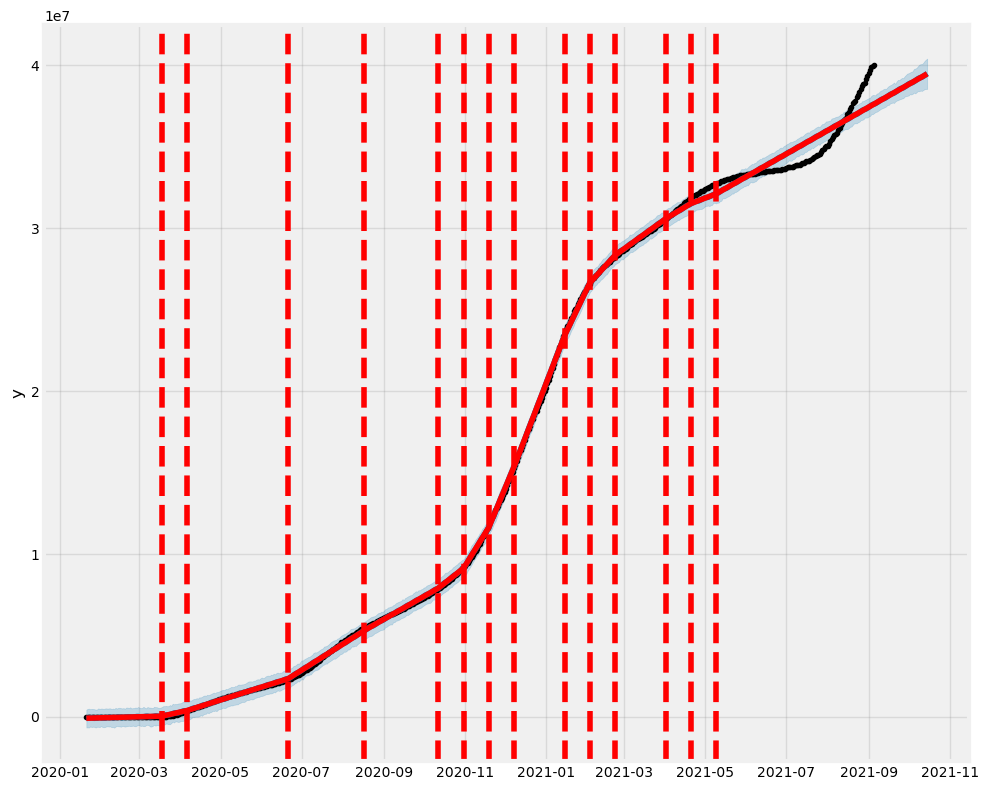

In [7]:
# Auto detect changepoints
m = Prophet()
m.fit(xdat)

future = m.make_future_dataframe(periods=40)
forecast = m.predict(future)

fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')
a = add_changepoints_to_plot(fig.gca(), m, forecast);

We will need to adjust / shrink the changepoint parameter `changepoint_prior_scale`

11:16:26 - cmdstanpy - INFO - Chain [1] start processing
11:16:26 - cmdstanpy - INFO - Chain [1] done processing


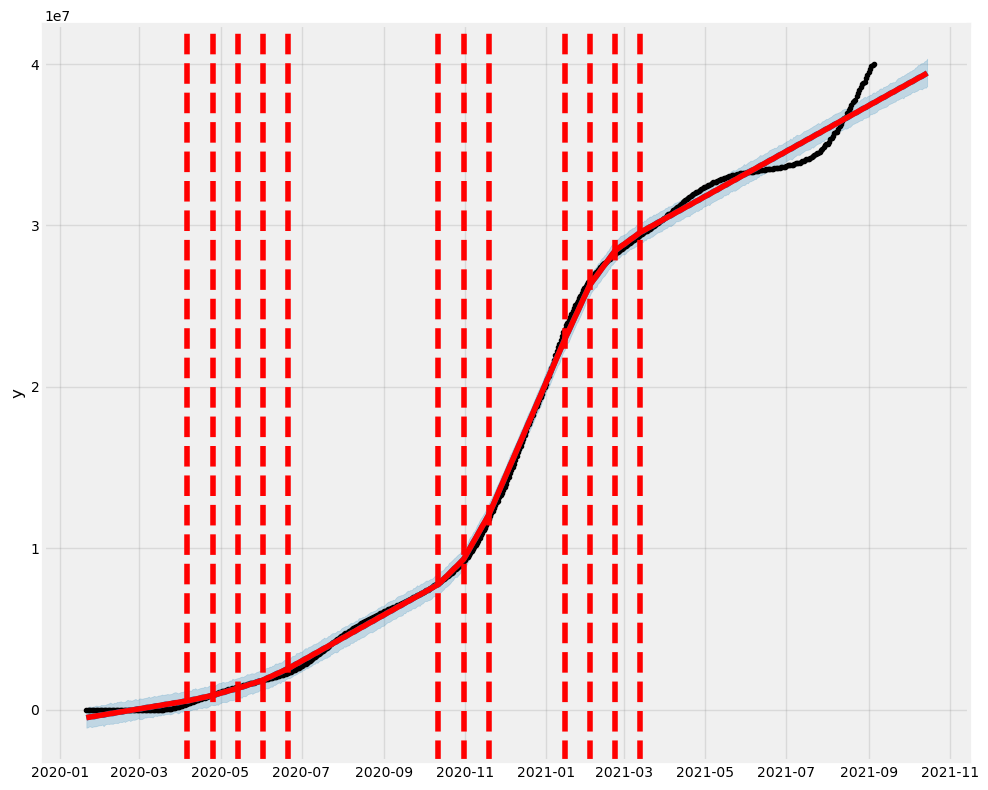

In [8]:
m = Prophet(changepoint_prior_scale=0.01)
m.fit(xdat)

future = m.make_future_dataframe(periods=40)
forecast = m.predict(future)

fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')
a = add_changepoints_to_plot(fig.gca(), m, forecast);

### Non Linear Growth

Non-linear, Saturating Growth, can be represented in the form of the logistic growth model which allows us to model the saturation phase of the growth cycles.

$$
T(t) = \frac{C_1} {1 + \exp(-k(t - m))}
$$

Where:
 - $C$ is the carrying capacity.
 - $k$ is the growth rate or the steepness of the trend curve.

Prophet allows for automatic and manual tuning of the variability. Building on the previous example, lets move to China's data on Covid cases.

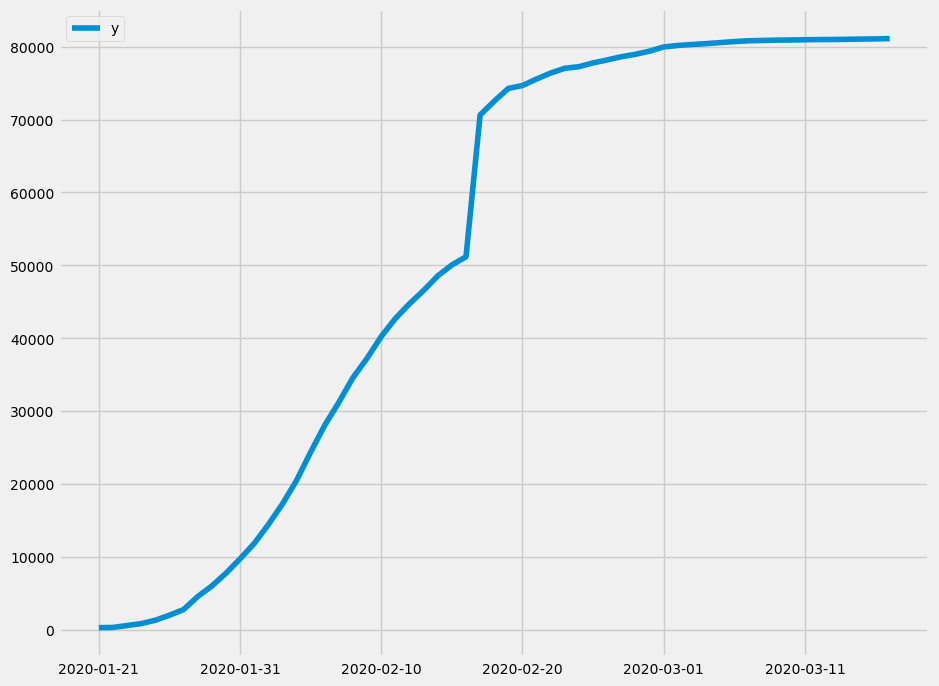

In [9]:
df = pd.read_csv(data + 'who-data/WHO_full_data2003.csv')
# Taking a subset of the data and renaming cols
df = df.loc[df['location'] == 'China'][['date', 'total_cases']].rename(columns={"date": "ds", "total_cases": "y"})
df.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='');

11:16:30 - cmdstanpy - INFO - Chain [1] start processing
11:16:30 - cmdstanpy - INFO - Chain [1] done processing


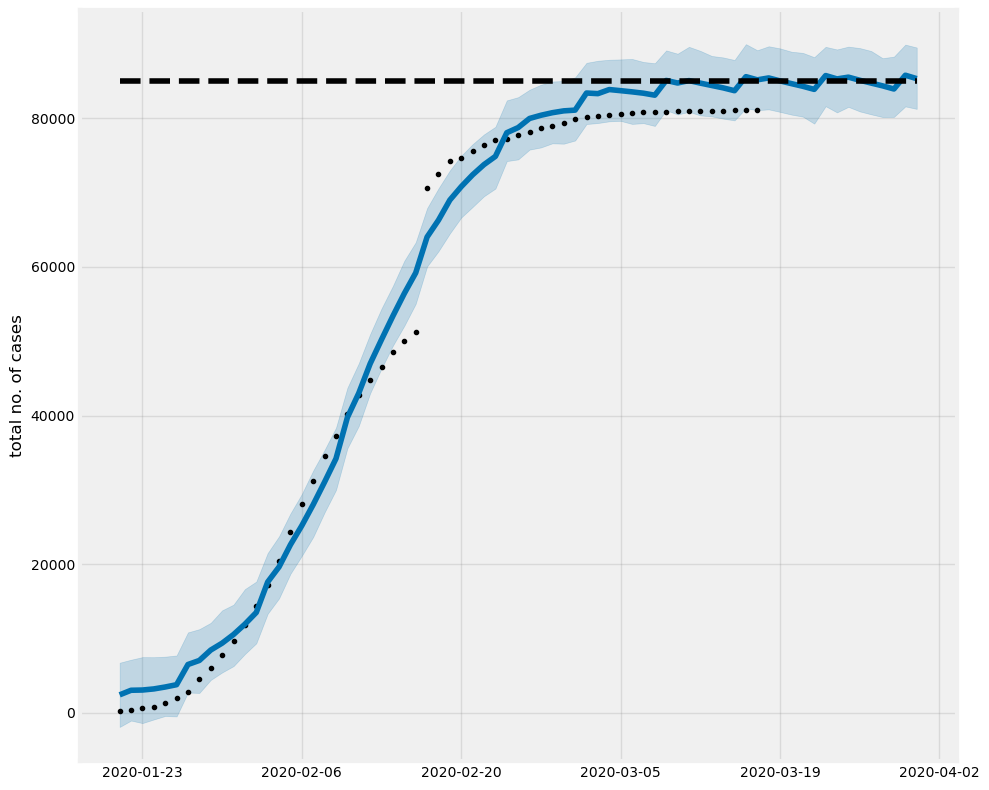

In [10]:
# Prophet can cap the forecast value as additional knowledge
df['cap'] = 85000

# Fit the model with growth parameter set to logistic.
m = Prophet(growth='logistic')
m.fit(df)
# Forecast
future = m.make_future_dataframe(periods=14)
future['cap'] = 85000
# Plot
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='', ylabel='total no. of cases');

11:16:30 - cmdstanpy - INFO - Chain [1] start processing
11:16:30 - cmdstanpy - INFO - Chain [1] done processing


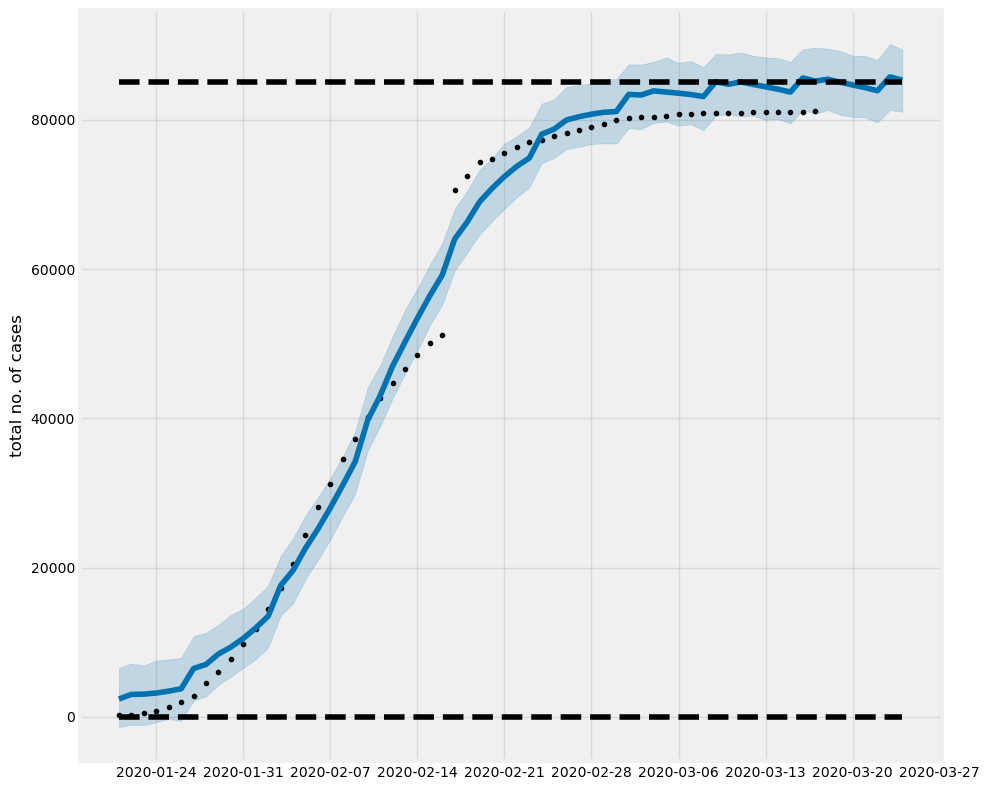

In [11]:
# The model can also incorporate about a floor as well as a cap
df['cap'] = 85000
df['floor'] = 0

# Fit the model
m = Prophet(growth='logistic')
m.fit(df)

# Predict
future = m.make_future_dataframe(periods=7)
future['cap'] = 85000
future['floor'] = 0
forecast = m.predict(future)
m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='', ylabel='total no. of cases');


## Seasonality

Multiple seasonalities, which occur in parallel, are a relfection of the complexity of modeling time series data. This is another reason why simple Exponential Smoothing just doesn't cut it. Even approaches taken for relatively "advanced" ARIMA models to handle multiple seasonalities is clunky (adding dummies).

Addressing this challenge is where Prophet differentiates itself through the use of [Fourier](https://mathworld.wolfram.com/FourierSeries.html) expansion:

$$
S(t) = \sum_{i=1}^{N} \left( a_i \cos\left(\frac{2 \pi i t}{P} \right) + b_i \sin\left(\frac{2 \pi i t}{P} \right) \right)
$$

Functions can be combined, as in GAMs.

In [ ]:
# Download additional datasets from Konrad's NB
#dataset = "robikscube/hourly-energy-consumption"
#download_path = "data/hourly-energy-consumption"

#download_data(dataset, download_path)

In [12]:
# Loading energy consumption data from PJM Interconnection LLC which is a regional transmission 
# organization in the US.
df = pd.read_csv(data + 'hourly-energy-consumption/pjm_hourly_est.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178262 entries, 0 to 178261
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  178262 non-null  datetime64[ns]
 1   AEP       121273 non-null  float64       
 2   COMED     66497 non-null   float64       
 3   DAYTON    121275 non-null  float64       
 4   DEOK      57739 non-null   float64       
 5   DOM       116189 non-null  float64       
 6   DUQ       119068 non-null  float64       
 7   EKPC      45334 non-null   float64       
 8   FE        62874 non-null   float64       
 9   NI        58450 non-null   float64       
 10  PJME      145366 non-null  float64       
 11  PJMW      143206 non-null  float64       
 12  PJM_Load  32896 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 17.7 MB


In [13]:
df.describe().round(2)

Datetime        AEP     COMED     DAYTON  \
count                         178262  121273.00  66497.00  121275.00   
mean   2008-06-01 15:46:51.203734016   15499.51  11420.15    2037.85   
min              1998-04-01 01:00:00    9581.00   7237.00     982.00   
25%              2003-05-02 09:15:00   13630.00   9780.00    1749.00   
50%              2008-06-01 16:30:00   15310.00  11152.00    2009.00   
75%              2013-07-03 00:45:00   17200.00  12510.00    2279.00   
max              2018-08-03 00:00:00   25695.00  23753.00    3746.00   
std                              NaN    2591.40   2304.14     393.40   

           DEOK        DOM        DUQ      EKPC        FE        NI  \
count  57739.00  116189.00  119068.00  45334.00  62874.00  58450.00   
mean    3105.10   10949.20    1658.82   1464.22   7792.16  11701.68   
min      907.00    1253.00    1014.00    514.00      0.00   7003.00   
25%     2687.00    9322.00    1444.00   1185.00   6807.00   9954.00   
50%     3013.00   10501.00    1630.00   1386.00   7700.00  11521.00   
75%     3449.00   12378.00    1819.00   1699.00   8556.00  12896.75   
max     5445.00   21651.00    3054.00   3490.00  14032.00  23631.00   
std      599.86    2413.95     301.74    378.87   1331.27   2371.50   

            PJME       PJMW  PJM_Load  
count  145366.00  143206.00  32896.00  
mean    32080.22    5602.38  29766.43  
min     14544.00     487.00  17461.00  
25%     27573.00    4907.00  25473.00  
50%     31421.00    5530.00  29655.00  
75%     35650.00    6252.00  33073.25  
max     62009.00    9594.00  54030.00  
std      6464.01     979.14   5849.77

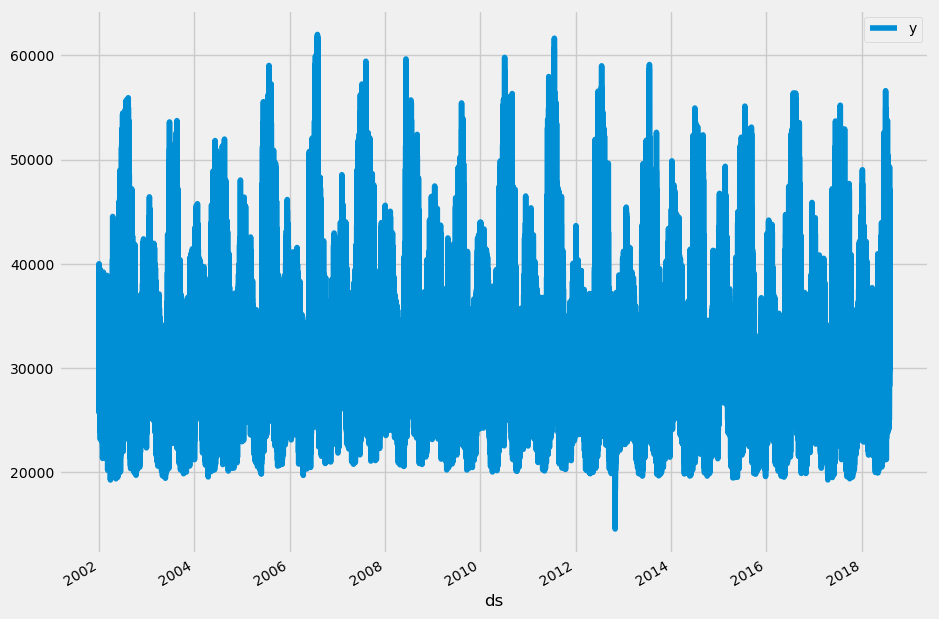

In [14]:
# Since Prophet is built for univariate data, we can pick a series.
# To demo additional out-of-the-box functionality, we will progressively aggregate
# to lower frequencies.

# Using Hourly
xdat = df[['Datetime', 'PJME']]
# Trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={'Datetime': 'ds', 'PJME': 'y'})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2));

11:16:59 - cmdstanpy - INFO - Chain [1] start processing
11:17:17 - cmdstanpy - INFO - Chain [1] done processing


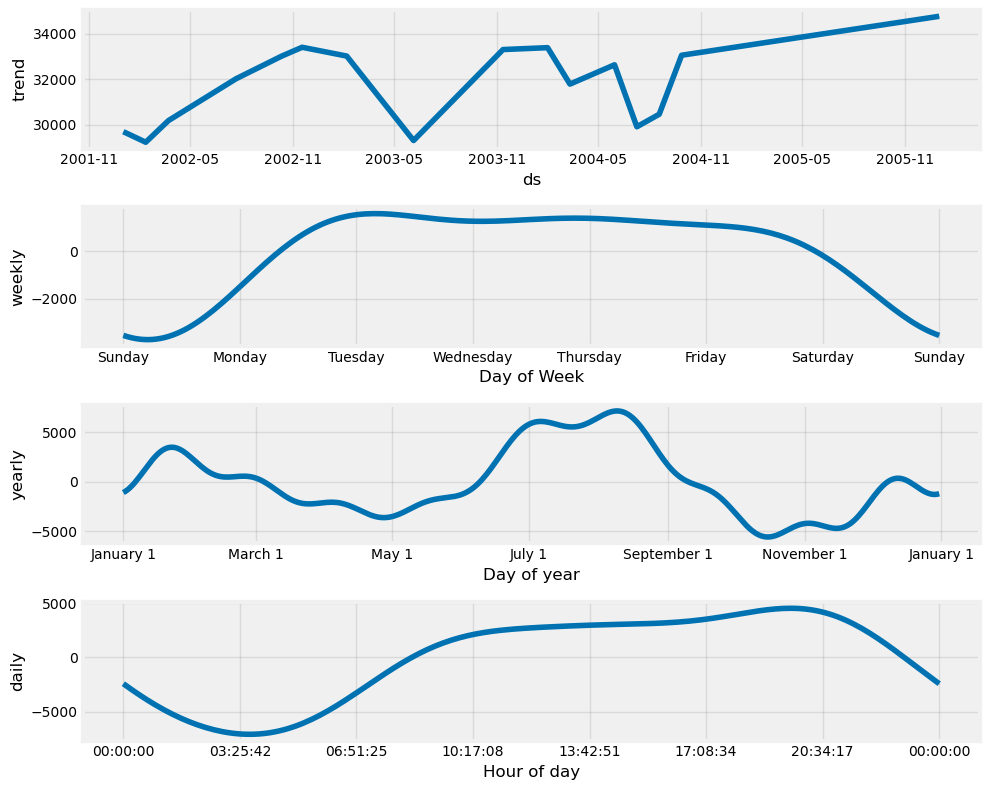

In [15]:
# Reducing the dataset for speed while keeping in mind that we will
# need to retain at least two complete cycles for each seasonality we want to model
m = Prophet().fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods=24, freq='H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2));

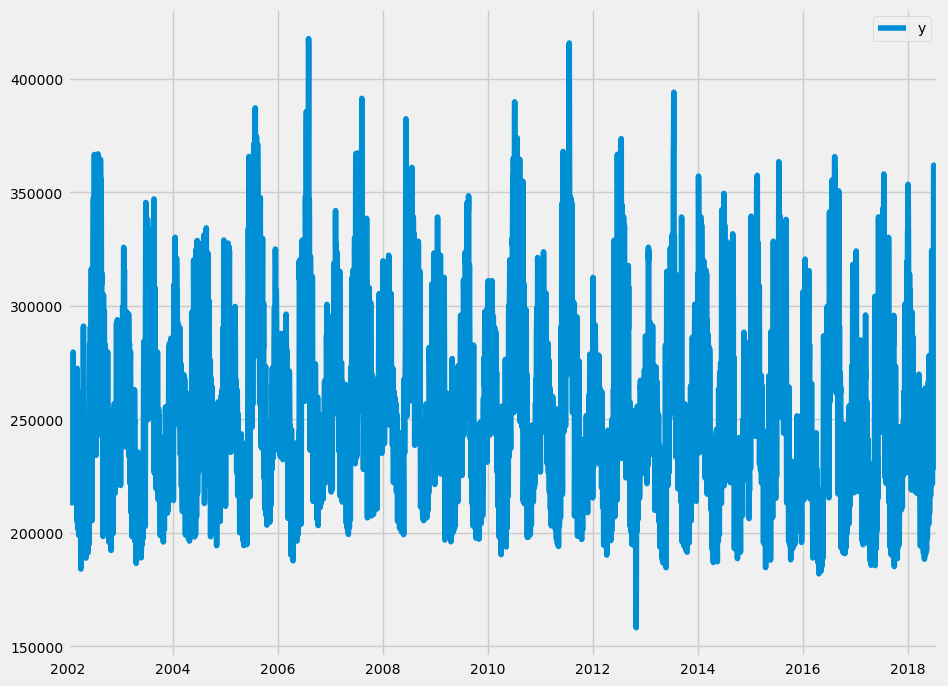

In [16]:
# Lets aggregate to daily frequency
xdat = df.resample('D', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={'Datetime': 'ds', 'PJME': 'y'})
xdat['y'] /= 10^9
# Purging the leading zeros along with the last observation - There are only a few hours of the last day in the sample
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '');

11:17:19 - cmdstanpy - INFO - Chain [1] start processing
11:17:20 - cmdstanpy - INFO - Chain [1] done processing


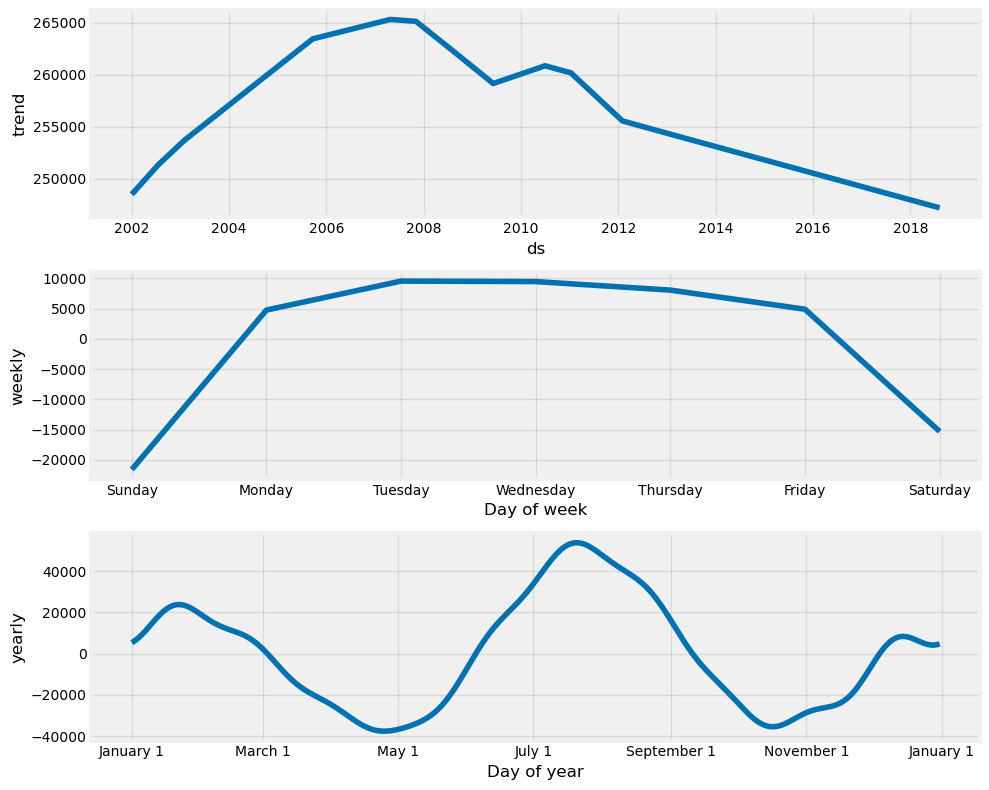

In [17]:
# Modeling over daily data
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 7, freq = 'D')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2));

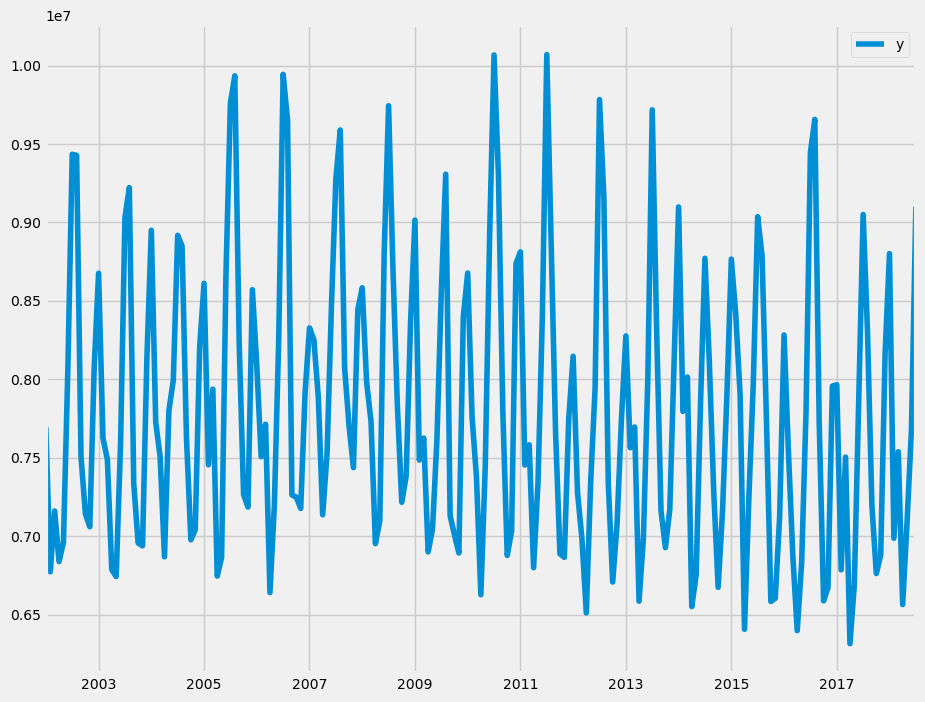

In [18]:
# Downsampling to monthly
xdat = df.resample('M', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9
# Same as beofre
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '');

11:17:21 - cmdstanpy - INFO - Chain [1] start processing
11:17:21 - cmdstanpy - INFO - Chain [1] done processing


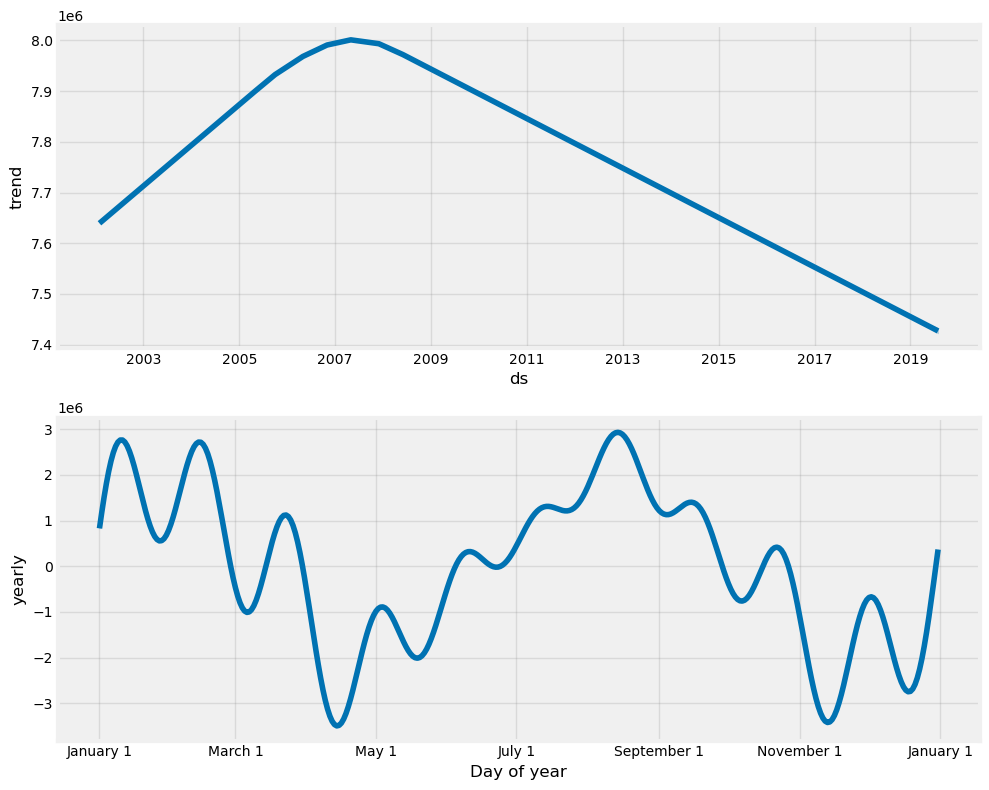

In [19]:
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 12, freq = 'M')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2));

### Seasonality Specification

Additional modelling options include setting the seasonality mode i.e. either additive or multiplicative.

11:17:30 - cmdstanpy - INFO - Chain [1] start processing
11:17:30 - cmdstanpy - INFO - Chain [1] done processing


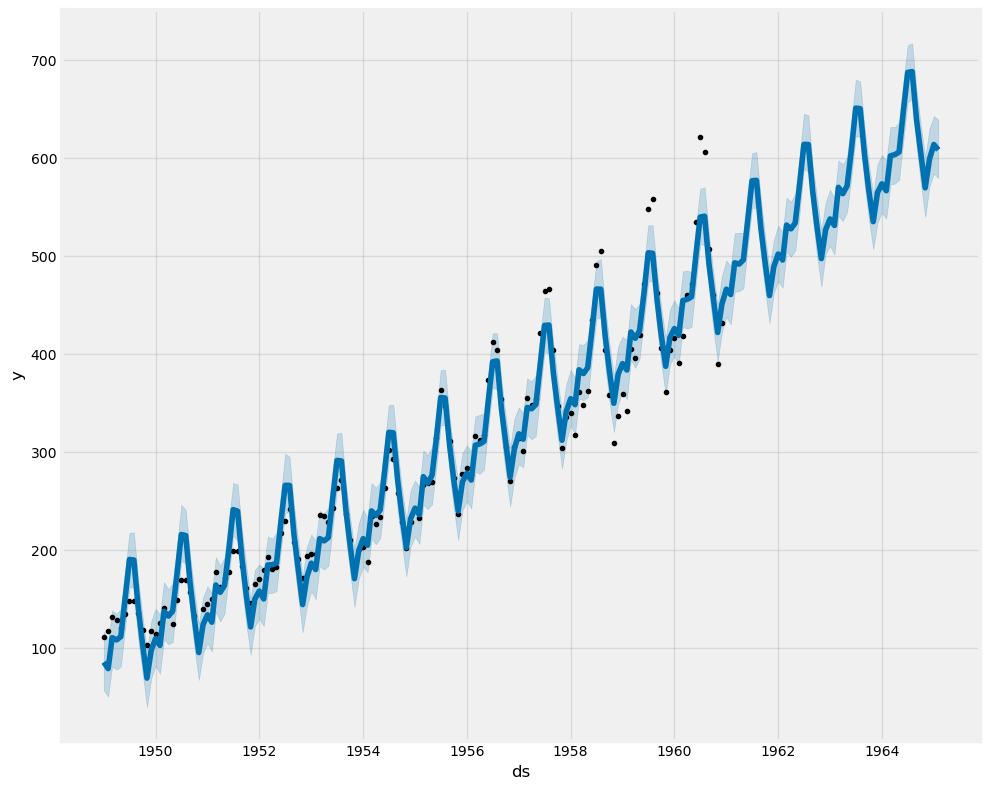

In [20]:
# First, using the air passengers dataset, we can see additive seasonality in action
df = pd.read_csv(data + 'example_air_passengers.csv')

m = Prophet(seasonality_mode='additive')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show();

11:17:30 - cmdstanpy - INFO - Chain [1] start processing
11:17:30 - cmdstanpy - INFO - Chain [1] done processing


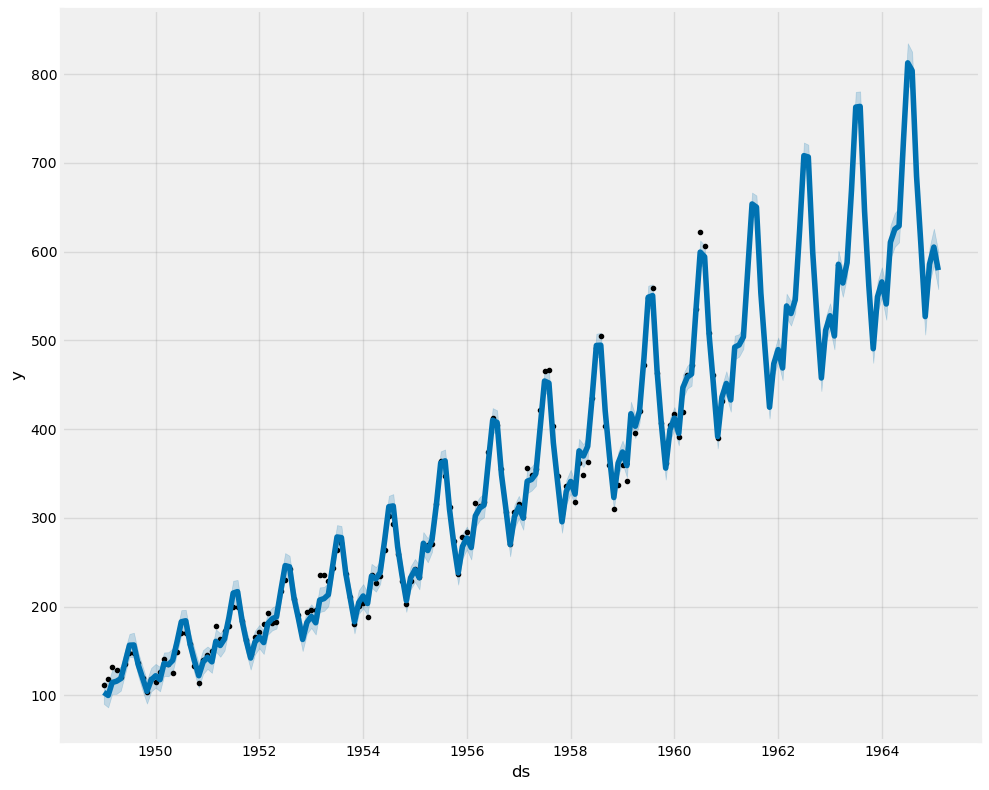

In [21]:
# Multiplicative modelling is the alternative method
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show();

In case there are strong seasonal components being observed, we can opt to leave them in - as in the plot above - or have them reduced. `seasonality_prior_scale` allows us to factor in how much the model will fit the seasonality in the data.

In [22]:
def f_cast(model, df):
    model.fit(df)
    future = model.make_future_dataframe(50, freq='MS')
    forecast = model.predict(future)
    fig = model.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
    plt.show();
    return forecast

In [23]:
m1 = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale = 1.5)
m2 = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale = 10)

11:17:34 - cmdstanpy - INFO - Chain [1] start processing
11:17:34 - cmdstanpy - INFO - Chain [1] done processing


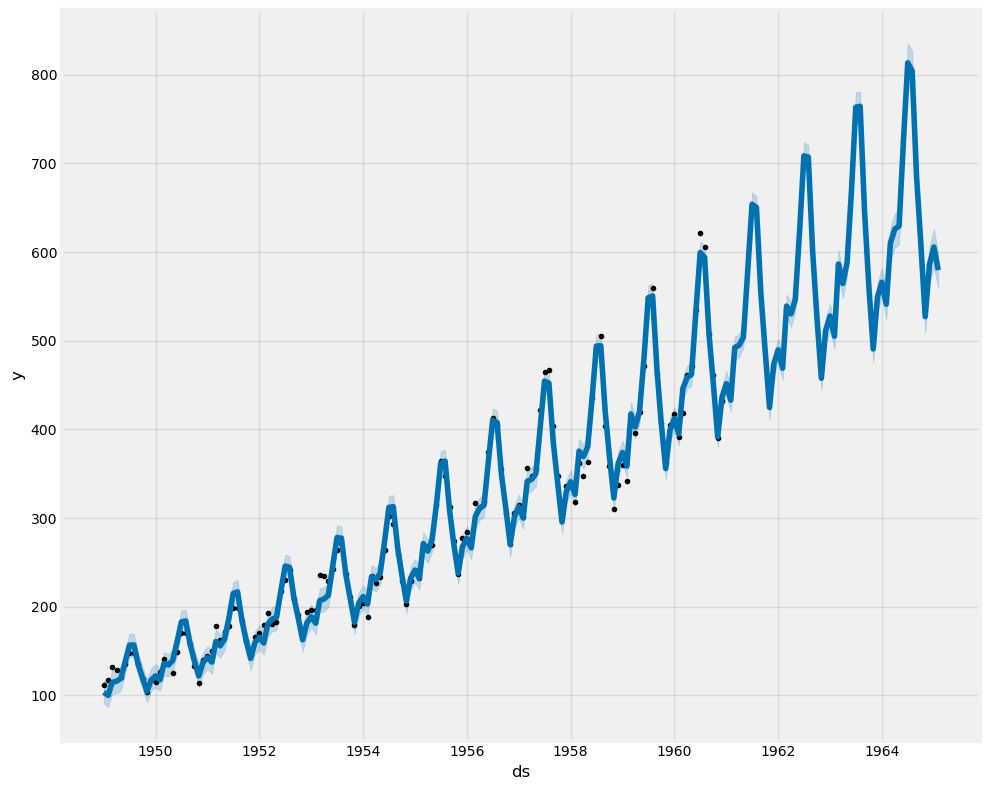

In [24]:
fcast1 = f_cast(m1, df)

11:17:35 - cmdstanpy - INFO - Chain [1] start processing
11:17:35 - cmdstanpy - INFO - Chain [1] done processing


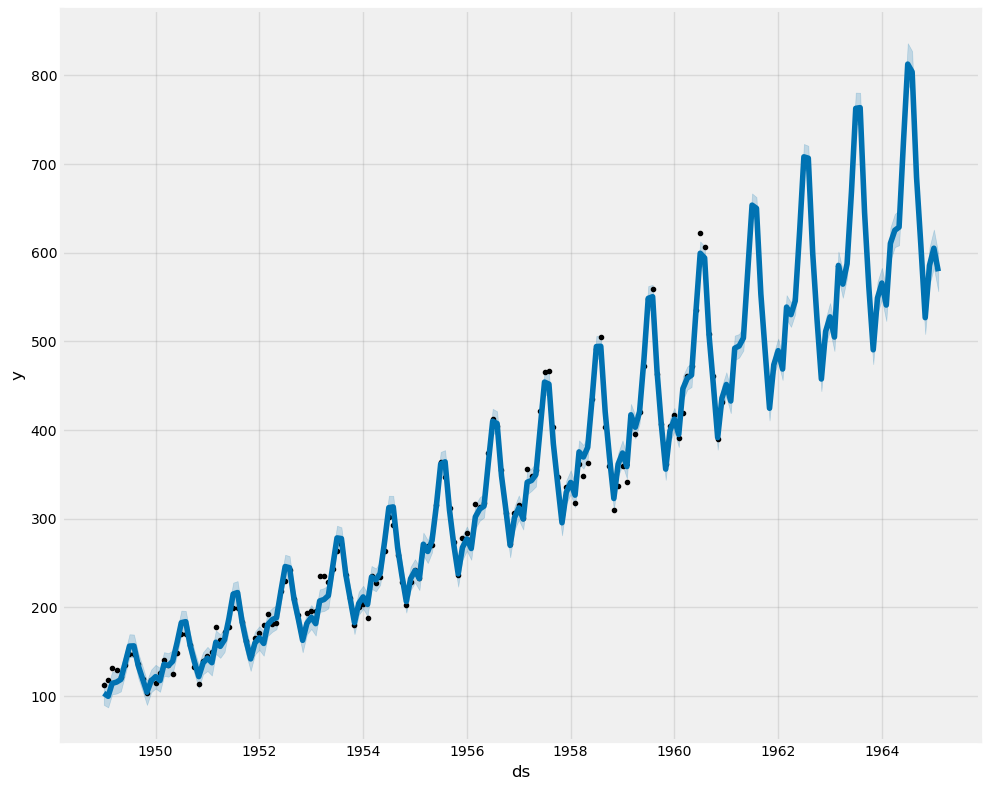

In [25]:
fcast2 = f_cast(m2, df)

In [26]:
fcast1  # Using 1.5 for the seasonality_prior scale

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   1949-01-01  113.857100   91.029975  116.975505   113.857100   113.857100   
1   1949-02-01  115.592502   86.605187  113.083199   115.592502   115.592502   
2   1949-03-01  117.159962  101.713508  128.419778   117.159962   117.159962   
3   1949-04-01  118.895364  102.365053  128.888052   118.895364   118.895364   
4   1949-05-01  120.574786  105.325096  132.777800   120.574786   120.574786   
..         ...         ...         ...         ...          ...          ...   
189 1964-10-01  654.773842  588.715944  629.869183   637.535155   670.466475   
190 1964-11-01  658.366614  508.137529  546.697555   640.645592   674.488832   
191 1964-12-01  661.843490  565.752877  606.103937   643.593137   678.366301   
192 1965-01-01  665.436261  582.847382  626.265927   646.510367   682.432706   
193 1965-02-01  669.029033  559.253526  598.891121   649.518132   686.535738   

     multiplicative_terms  multiplicative_terms_lower  \
0               -0.089829                   -0.089829   
1               -0.133645                   -0.133645   
2               -0.021186                   -0.021186   
3               -0.022866                   -0.022866   
4               -0.012002                   -0.012002   
..                    ...                         ...   
189             -0.068350                   -0.068350   
190             -0.199237                   -0.199237   
191             -0.114566                   -0.114566   
192             -0.089829                   -0.089829   
193             -0.133645                   -0.133645   

     multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
0                     -0.089829 -0.089829     -0.089829     -0.089829   
1                     -0.133645 -0.133645     -0.133645     -0.133645   
2                     -0.021186 -0.021186     -0.021186     -0.021186   
3                     -0.022866 -0.022866     -0.022866     -0.022866   
4                     -0.012002 -0.012002     -0.012002     -0.012002   
..                          ...       ...           ...           ...   
189                   -0.068350 -0.068350     -0.068350     -0.068350   
190                   -0.199237 -0.199237     -0.199237     -0.199237   
191                   -0.114566 -0.114566     -0.114566     -0.114566   
192                   -0.089829 -0.089829     -0.089829     -0.089829   
193                   -0.133645 -0.133645     -0.133645     -0.133645   

     additive_terms  additive_terms_lower  additive_terms_upper        yhat  
0               0.0                   0.0                   0.0  103.629436  
1               0.0                   0.0                   0.0  100.144183  
2               0.0                   0.0                   0.0  114.677762  
3               0.0                   0.0                   0.0  116.176702  
4               0.0                   0.0                   0.0  119.127706  
..              ...                   ...                   ...         ...  
189             0.0                   0.0                   0.0  610.019723  
190             0.0                   0.0                   0.0  527.195492  
191             0.0                   0.0                   0.0  586.018643  
192             0.0                   0.0                   0.0  605.660819  
193             0.0                   0.0                   0.0  579.616884  

[194 rows x 16 columns]

In [27]:
fcast2 # Using 10, which is the default value for comparison

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   1949-01-01  113.457154   90.110673  116.290544   113.457154   113.457154   
1   1949-02-01  115.212069   87.282972  112.625836   115.212069   115.212069   
2   1949-03-01  116.797153  102.052754  127.426785   116.797153   116.797153   
3   1949-04-01  118.552067  102.873177  128.553747   118.552067   118.552067   
4   1949-05-01  120.250372  105.294828  132.593197   120.250372   120.250372   
..         ...         ...         ...         ...          ...          ...   
189 1964-10-01  654.471733  588.118369  629.765136   637.768269   670.332243   
190 1964-11-01  658.056578  508.371239  544.959441   640.784329   674.473994   
191 1964-12-01  661.525783  563.691757  605.861551   643.317936   678.431577   
192 1965-01-01  665.110628  582.917869  626.151030   646.194285   682.498775   
193 1965-02-01  668.695474  556.584303  599.005189   648.912866   686.769696   

     multiplicative_terms  multiplicative_terms_lower  \
0               -0.090209                   -0.090209   
1               -0.133979                   -0.133979   
2               -0.021072                   -0.021072   
3               -0.023166                   -0.023166   
4               -0.012221                   -0.012221   
..                    ...                         ...   
189             -0.068661                   -0.068661   
190             -0.199448                   -0.199448   
191             -0.114700                   -0.114700   
192             -0.090209                   -0.090209   
193             -0.133979                   -0.133979   

     multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
0                     -0.090209 -0.090209     -0.090209     -0.090209   
1                     -0.133979 -0.133979     -0.133979     -0.133979   
2                     -0.021072 -0.021072     -0.021072     -0.021072   
3                     -0.023166 -0.023166     -0.023166     -0.023166   
4                     -0.012221 -0.012221     -0.012221     -0.012221   
..                          ...       ...           ...           ...   
189                   -0.068661 -0.068661     -0.068661     -0.068661   
190                   -0.199448 -0.199448     -0.199448     -0.199448   
191                   -0.114700 -0.114700     -0.114700     -0.114700   
192                   -0.090209 -0.090209     -0.090209     -0.090209   
193                   -0.133979 -0.133979     -0.133979     -0.133979   

     additive_terms  additive_terms_lower  additive_terms_upper        yhat  
0               0.0                   0.0                   0.0  103.222279  
1               0.0                   0.0                   0.0   99.776094  
2               0.0                   0.0                   0.0  114.336052  
3               0.0                   0.0                   0.0  115.805724  
4               0.0                   0.0                   0.0  118.780781  
..              ...                   ...                   ...         ...  
189             0.0                   0.0                   0.0  609.535095  
190             0.0                   0.0                   0.0  526.808371  
191             0.0                   0.0                   0.0  585.648481  
192             0.0                   0.0                   0.0  605.111556  
193             0.0                   0.0                   0.0  579.104454  

[194 rows x 16 columns]

In [28]:
# Assessing relative impact using abs % differences
cols = ['trend', 'multiplicative_terms', 'yearly', 'yhat']
diff = ((fcast1[cols] - fcast2[cols]) / ((fcast1[cols] + fcast2[cols])/2))*100
diff

trend  multiplicative_terms    yearly      yhat
0    0.351888             -0.422365 -0.422365  0.393670
1    0.329659             -0.249721 -0.249721  0.368236
2    0.310150              0.543543  0.543543  0.298418
3    0.289156             -1.302166 -1.302166  0.319833
4    0.269419             -1.812999 -1.812999  0.291646
..        ...                   ...       ...       ...
189  0.046150             -0.453146 -0.453146  0.079476
190  0.047103             -0.105853 -0.105853  0.073457
191  0.048015             -0.117170 -0.117170  0.063185
192  0.048947             -0.422365 -0.422365  0.090729
193  0.049870             -0.249721 -0.249721  0.088447

[194 rows x 4 columns]

In [29]:
diff.describe().round(3)

trend  multiplicative_terms   yearly     yhat
count  194.000               194.000  194.000  194.000
mean    -0.005                -1.195   -1.195    0.016
std      0.098                 6.439    6.439    0.102
min     -0.200               -44.766  -44.766   -0.194
25%     -0.060                -0.250   -0.250   -0.047
50%     -0.006                -0.052   -0.052    0.017
75%      0.037                 0.138    0.138    0.062
max      0.352                 2.253    2.253    0.394

#### **Interval Forecasts**

Interval forecasts allow point estimates to be combined with uncertainty. The default for the `mcmc_samples` is 0 and to get intervals around seasonality, full Bayesian sampling is needed. Uncertainty around the trend is calculated with Maximum A Posteriori (MAP).

**Now, there is a lot of discussion these days around uncertainty quantification and the role of Bayesian approaches versus Conformal Prediction. The views are really strong on both sides. Being a responsible data professional means assessing the merits and tradeoffs with both schools of thought, while setting up carefully structured deep dives.**

In [30]:
## Moving back to the energy dataset
df = pd.read_csv('data/hourly-energy-consumption/pjm_hourly_est.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
xdat = df[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={"Datetime": "ds", "PJME": "y"})

In [31]:
# Update forecasting function
def forecast(m, df, p, f):
    m = m.fit(df)
    future = m.make_future_dataframe(periods=p, freq=f)
    forecast = m.predict(future)
    m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2));

11:18:03 - cmdstanpy - INFO - Chain [1] start processing
11:18:19 - cmdstanpy - INFO - Chain [1] done processing


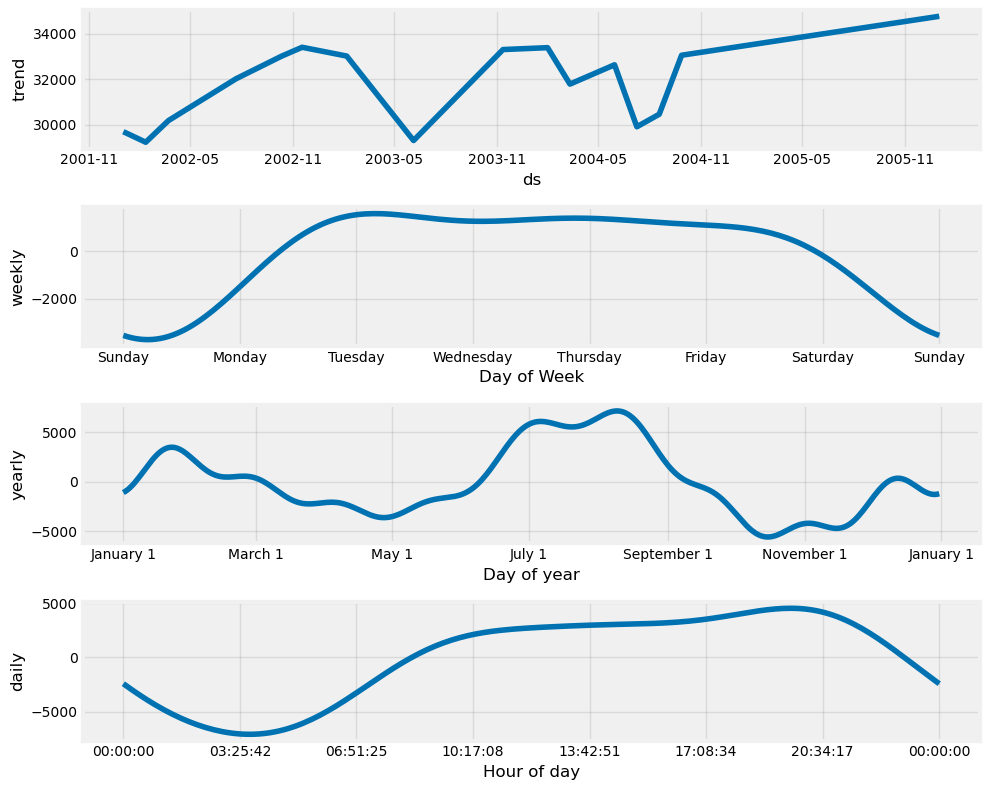

In [32]:
# Recreating the trend and seasonality model
forecast(Prophet(), xdat.iloc[:30000], 24, 'H')

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

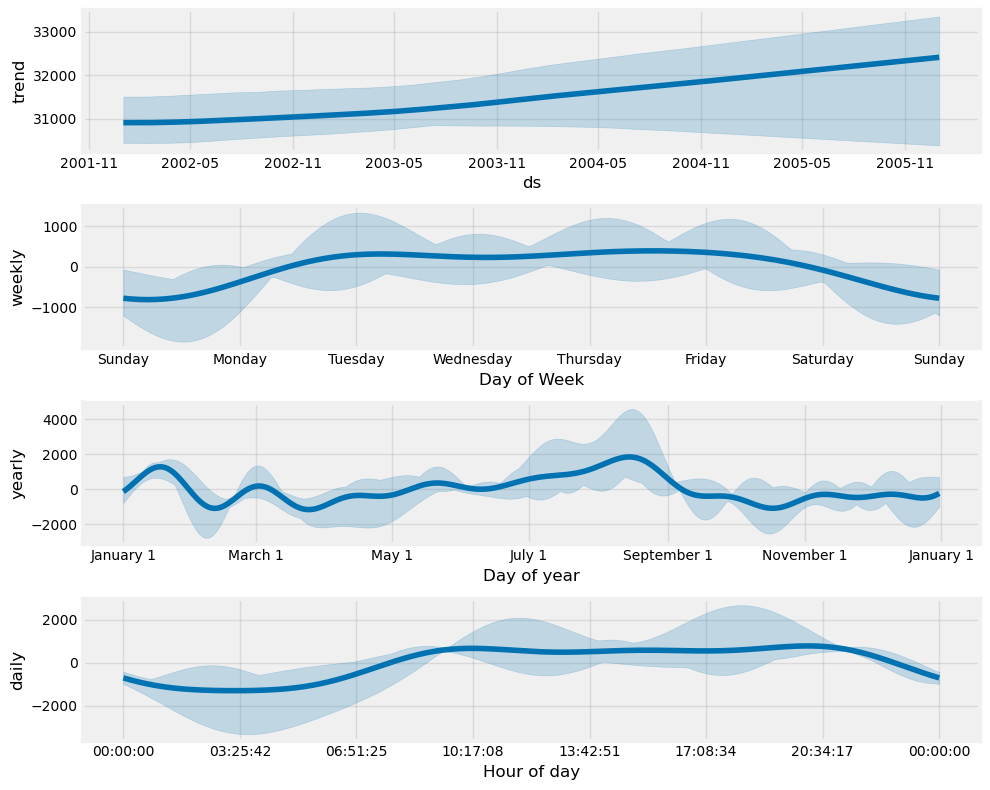

In [33]:
import logging
# Disabling a verbose sampling warning error
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

# Switching to Bayesian inference and using positive integers
forecast(Prophet(mcmc_samples=10),  xdat.iloc[:30000], 24, 'H')

## Handling Special Days

Special days / events, such as holidays, geo-political or world events - such as wars or major sporting events - etc., can have measurable impacts on forecasting performance. They need to be handling separately from trends and seasonality.

### Holidays

In [ ]:
# Download additional datasets from Konrad's NB
#dataset = "konradb/norway-bicycles"
#download_path = "data/norway-bicycles"

#download_data(dataset, download_path)

In [34]:
# Loading Bike ride data
bikerides = pd.read_csv('data/norway-bicycles/bikerides_day.csv', encoding='unicode_escape', delimiter=',')
bikerides.head()

Date  Volume  Rain  Temp
0  2016-11-17   933.0   9.0   2.1
1  2016-11-18  1197.0   6.7   3.9
2  2016-11-19   243.0   5.4   2.0
3  2016-11-20   234.0   3.9   2.8
4  2016-11-21  2148.0   7.3   2.8

In [35]:
bikerides.describe()

Volume         Rain         Temp
count  1273.000000  1273.000000  1273.000000
mean   2609.344855     1.945640     6.783975
std    1968.623825     4.505151     7.726084
min      63.000000     0.000000   -11.400000
25%    1185.000000     0.000000     0.700000
50%    2073.000000     0.000000     5.500000
75%    3801.000000     1.400000    13.400000
max    8679.000000    39.500000    25.900000

In [36]:
# Reformatting
bikerides = bikerides[['Date', 'Volume']].rename(columns={"Date": "ds", "Volume": "y"})

In [37]:
# Lets see which Norwegian holidays are listed in the model
m = Prophet()
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
# List names
m.train_holiday_names

0              New Year's Day
1             Maundy Thursday
2                 Good Friday
3               Easter Sunday
4               Easter Monday
5                   Labor Day
6            Constitution Day
7               Ascension Day
8                 Whit Sunday
9                 Whit Monday
10              Christmas Day
11    Second Day of Christmas
dtype: object

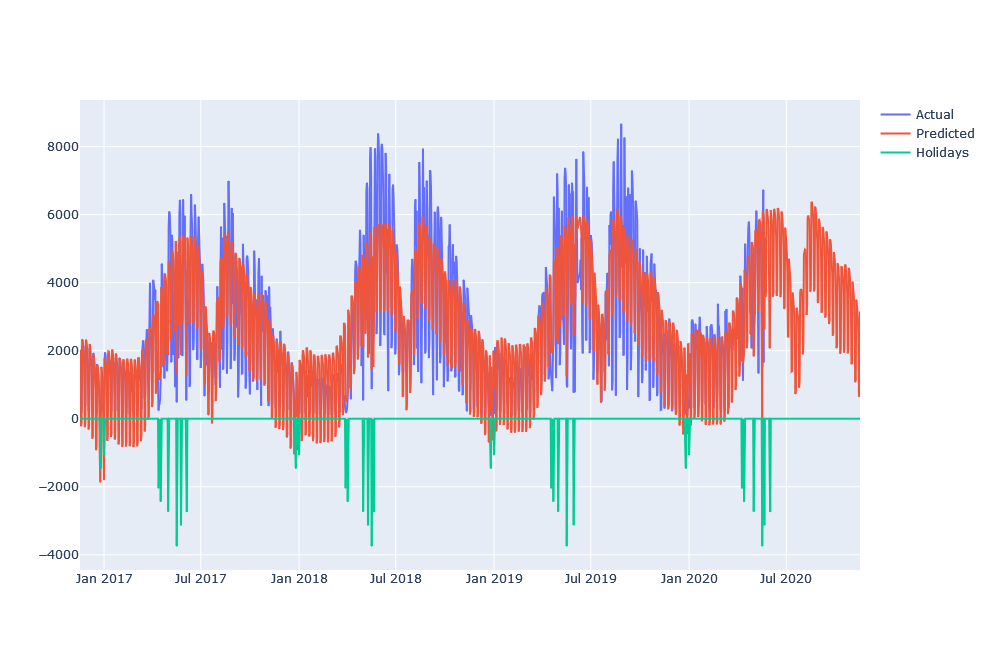

In [38]:
# Creating future dataframe
future = m.make_future_dataframe(periods=180, freq='D')
forecast = m.predict(future)

# Moving over to plotly for easier overlays
fig = go.Figure(layout={'height': 650})
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual')) # Bike Ride layer
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted')) # Forecast Layer
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays')) # Holidays
fig.show()

There seems to be an issue with the predictions during Christmas, so the data points need augmentation before passing to the model. According to Konrad's NB:

> `ds` - so we know when the holiday of interest occurs.
> 
> `lower_window` and `upper_window`: those two parameters allow us to incorporate the effect before/after the date, respectively. In our example below lower_window equals -1, meaning we anticipate a drop in the number of commuters a day before Christmas, whereas upper_window is 7 - with a lot of people taking time off between Christmas and New Year, the bicycle traffic is likely to decrease for approximately a week.


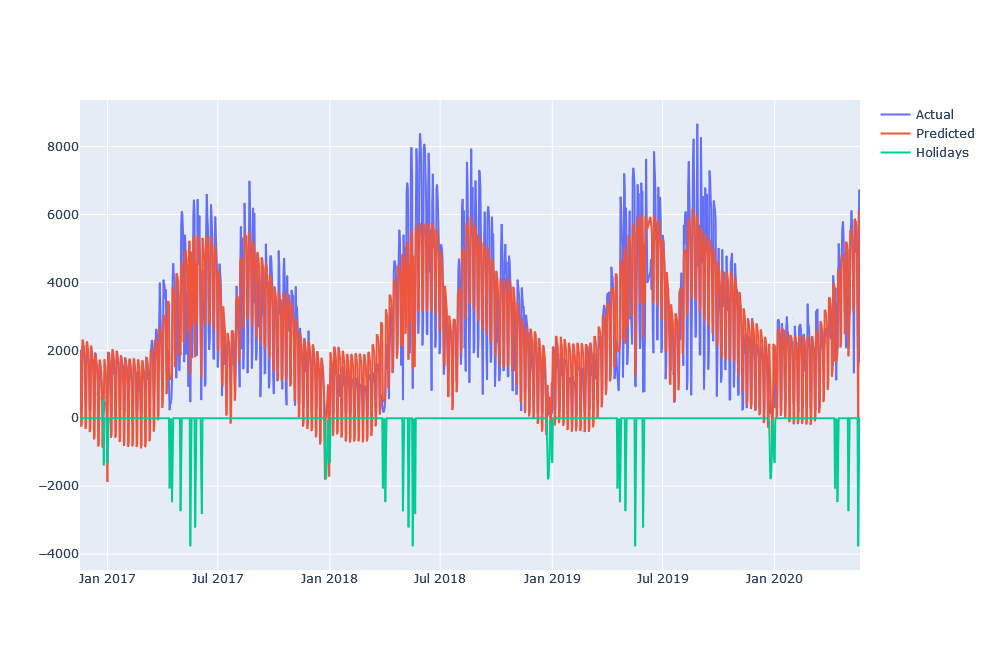

In [39]:
christmas = pd.DataFrame({
    'holiday' : 'Christmas',
    'ds' : pd.to_datetime(['2017-12-24', '2018-12-24', '2019-12-24', '2020-12-24']),
    'lower_window': -1,
    'upper_window': 7
})

m = Prophet(holidays=christmas)
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
forecast = m.predict(future)

fig = go.Figure(layout={'height': 650})
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

### Outliers

We will use Wikipedia's dataset of the log of daily count of visits to the Wikipedia page of the R language to see how Prphet handles outliers.

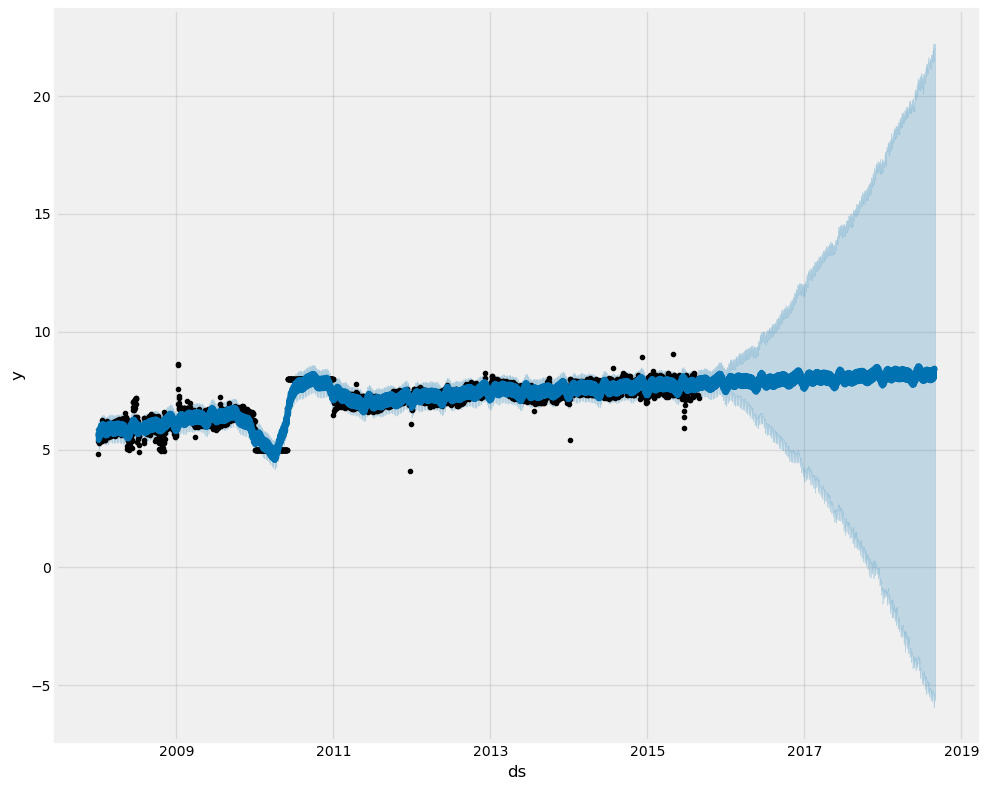

In [40]:
df = pd.read_csv('data/example_wp_log_R_outliers1.csv')

m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2));

The misspecification for the trend is mostl likely due to the odd flat lines and jump in 2011. We can replace erroneous observations directly in the dataframe.

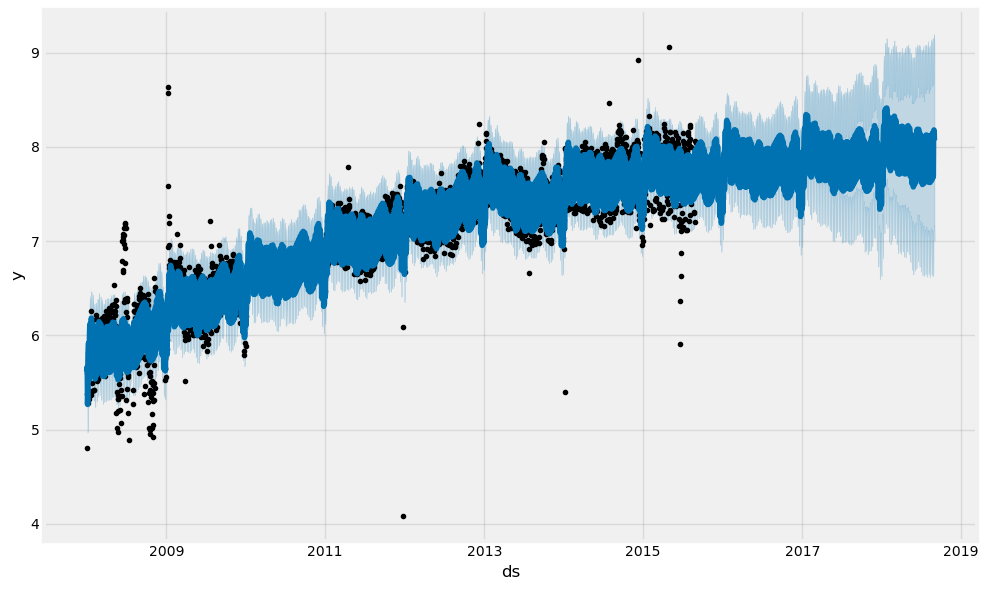

In [41]:
df.loc[(df['ds'] > '2010-01-01') & (df['ds'] < '2011-01-01'), 'y'] = None
m = Prophet().fit(df)
fig = m.plot(m.predict(future))
plt.show()

Apart from odd discontinuities, the more frequent scenario involves the handling of extreme values.

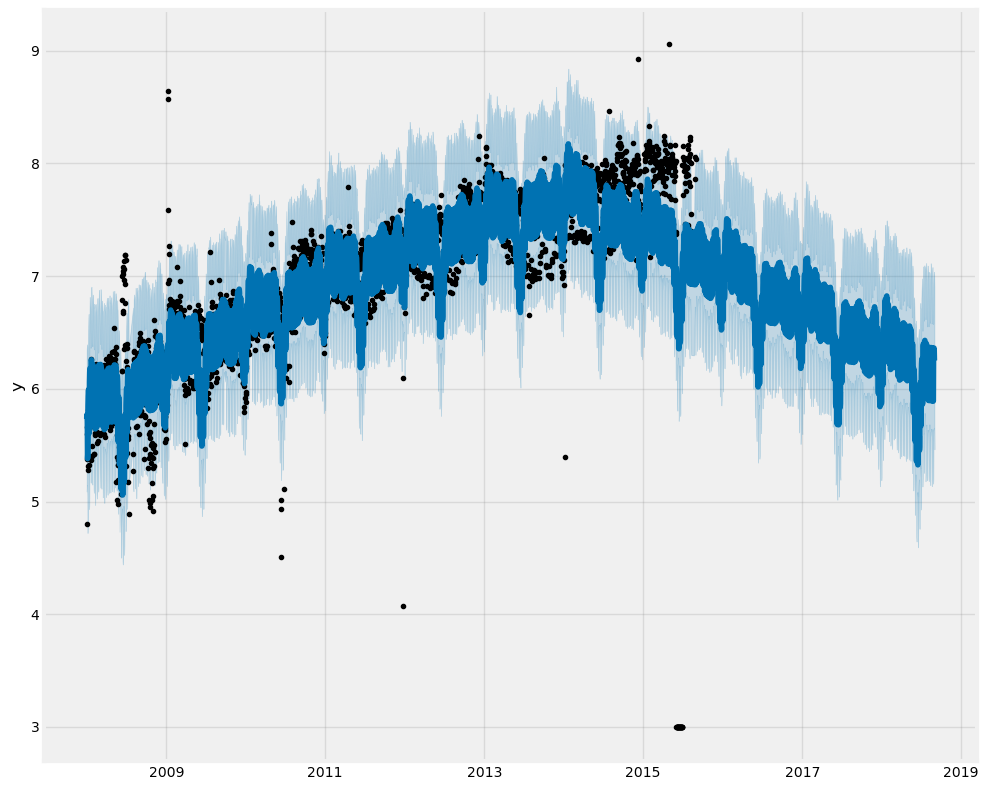

In [42]:
# Moving to the second wikipedia log dataset
df = pd.read_csv('data/example_wp_log_R_outliers2.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
plt.show()

In [43]:
df.describe()

y
count  2726.000000
mean      7.034725
std       0.785091
min       3.000000
25%       6.627379
50%       7.196312
75%       7.571345
max       9.057539

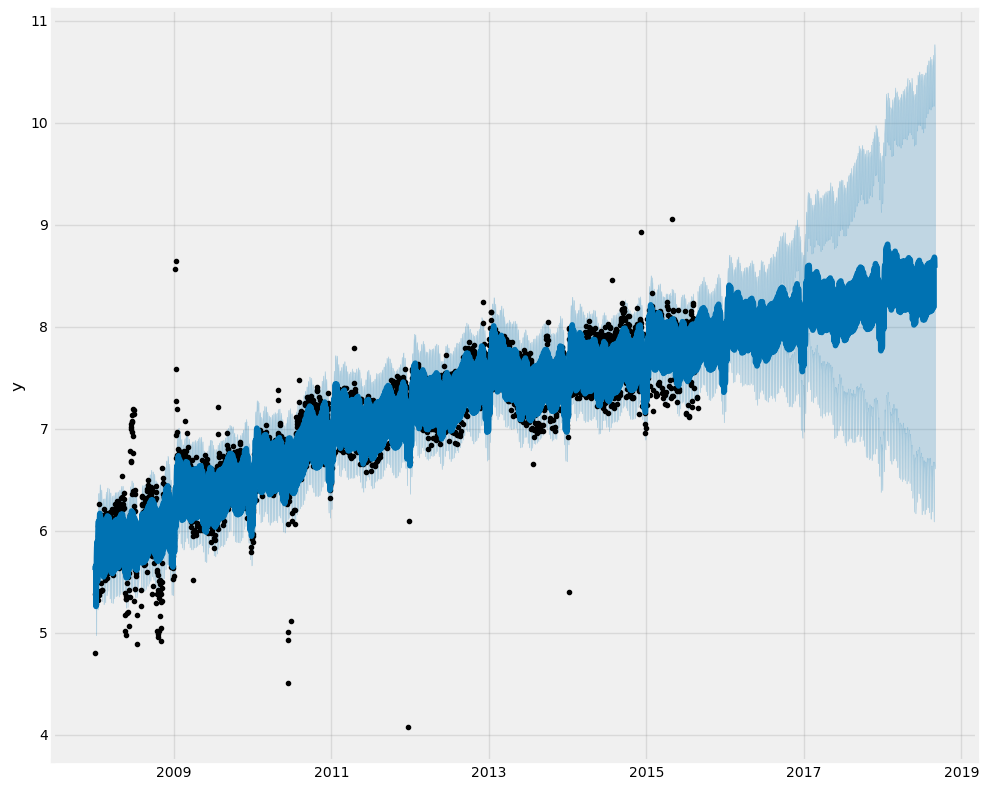

In [44]:
# Outliers can simply be dropped and the model will handle interpolation 

df.loc[(df['ds'] > '2015-06-01') & (df['ds'] < '2015-06-30'), 'y'] = None
m = Prophet().fit(df)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
plt.show()

## Perfomance Evaluation

Cross validation is handled using the `cross_validation` function where we will need to specify the forecast horizon, the (optional) initial training period `initial` and the spacing between the cut-off dates.

In [45]:
# By default, the initial training period is set to 3x the horizon and cutoffs are made every half a horizon
df_cv = cross_validation(m, initial='1000 days', period = '30 days', horizon='30 days')

  0%|          | 0/59 [00:00<?, ?it/s]

In [46]:
# At the cutoff, the values returned will be
# ds                   - timepoint in test set
# y                    - true value at ds
# yhat_(lower & upper) - upper and lower bounds of the confidence intervals
df_cv.head(10)

ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2010-10-27  7.057568    6.699713    7.413197  7.370860 2010-10-26
1 2010-10-28  7.054181    6.690986    7.404802  7.407318 2010-10-26
2 2010-10-29  6.969475    6.639570    7.315311  7.237778 2010-10-26
3 2010-10-30  6.626001    6.273239    7.001463  6.742881 2010-10-26
4 2010-10-31  6.611025    6.264658    6.963962  6.884487 2010-10-26
5 2010-11-01  7.004486    6.658238    7.340939  7.235619 2010-10-26
6 2010-11-02  7.091170    6.723069    7.448201  7.195937 2010-10-26
7 2010-11-03  7.127862    6.798081    7.472123  7.145984 2010-10-26
8 2010-11-04  7.139251    6.812535    7.461587  7.313887 2010-10-26
9 2010-11-05  7.068963    6.727498    7.427631  7.187657 2010-10-26

In [47]:
# Summarizing the performance metrics
df_p = performance_metrics(df_cv)
df_p.head(5)

horizon       mse      rmse       mae      mape     mdape     smape  \
0  3 days  0.094815  0.307920  0.167496  0.024277  0.017309  0.023216   
1  4 days  0.094644  0.307643  0.167799  0.024243  0.017329  0.023199   
2  5 days  0.083742  0.289382  0.159022  0.023199  0.017303  0.022116   
3  6 days  0.037171  0.192798  0.145202  0.019582  0.016103  0.019576   
4  7 days  0.036547  0.191173  0.145910  0.019767  0.015717  0.019740   

   coverage  
0  0.924582  
1  0.918734  
2  0.935673  
3  0.906843  
4  0.918744

## **The Full Prophet Pipeline**

In [48]:
# Loading the Superstore data to run through the entire model pipeline
df = pd.read_excel('data/Sample - Superstore.xls')
# Filtering down to furniture
df = df.loc[df['Category'] == 'Furniture']
# Unnecessary cols
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID',
        'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region',
        'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
df.drop(cols, axis=1, inplace=True)
# Sorting by date and summing up daily sales
df = df.sort_values('Order Date')
df = df.groupby('Order Date')['Sales'].sum().reset_index()
# Augmenting for ingestion by Prophet
df.rename(columns={"Order Date": "ds", "Sales": "y"}, inplace=True)

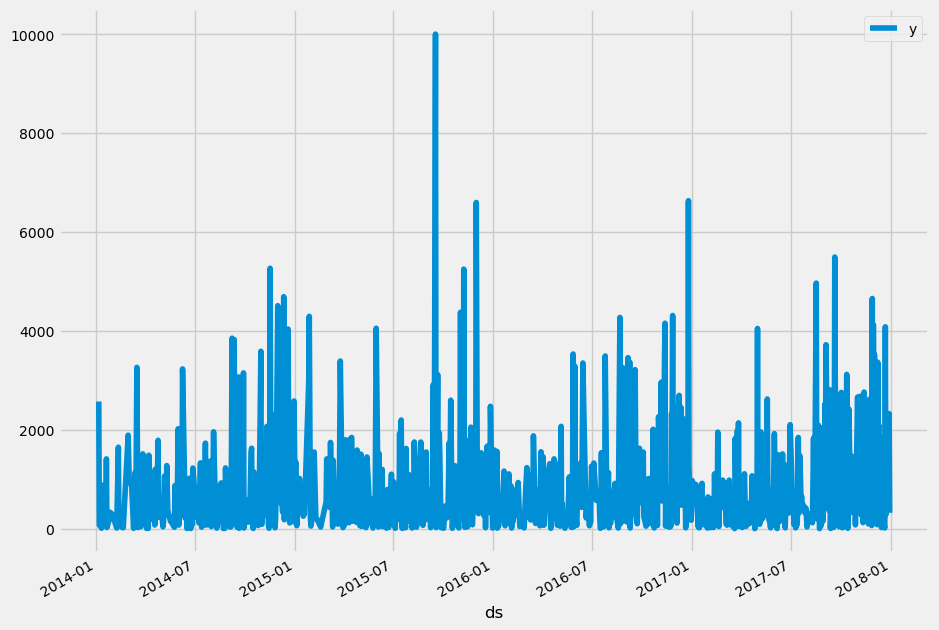

In [49]:
# Since we are working with Prophet, we can stick to daily frequencies which can contain missing values
df.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2));

In [50]:
# Checking time range
min(df['ds']), max(df['ds'])

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [51]:
# There are 4 complete annual cycles, so we will keep the last quarter of 2017 for validation
df_train = df.loc[df['ds'] < '2017-10-01']
df_valid = df.loc[df['ds'] >= '2017-10-01']
print(df_train.shape, df_valid.shape)

(810, 2) (79, 2)


In [52]:
# Setting hyperparameters
# For demo purposes, we will keep the selection limited to speed things up.
param_grid = {
    'changepoint_prior_scale' : [0.001, 0.1],
    #'seasonality_prior_scale' : [0.01, 1.0],
    #'holidays_prior_scale' : [0.01, 0.1],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate combos of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# We will story RMSE evals in this list
rmses = []

all_params

[{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'multiplicative'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}]

In [54]:
for params in all_params:
    # Cycle through param combos over the entire dataset
    m = Prophet(**params).fit(df)
    # Cross validation
    df_cv = cross_validation(m, initial='100 days', period='30 days', horizon='30 days', parallel='processes')
    # Performance metrics
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best params
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# Pick best
best_params = all_params[np.argmin(rmses)]
print(best_params)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization

   changepoint_prior_scale seasonality_mode         rmse
0                    0.001         additive  8545.813475
1                    0.001   multiplicative  2544.182390
2                    0.100         additive  3882.772779
3                    0.100   multiplicative  2108.152621
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


With these tuned params we can now setup the complete model.

In [55]:
m = Prophet(**params)
m.add_country_holidays(country_name='US')
m.fit(df_train)

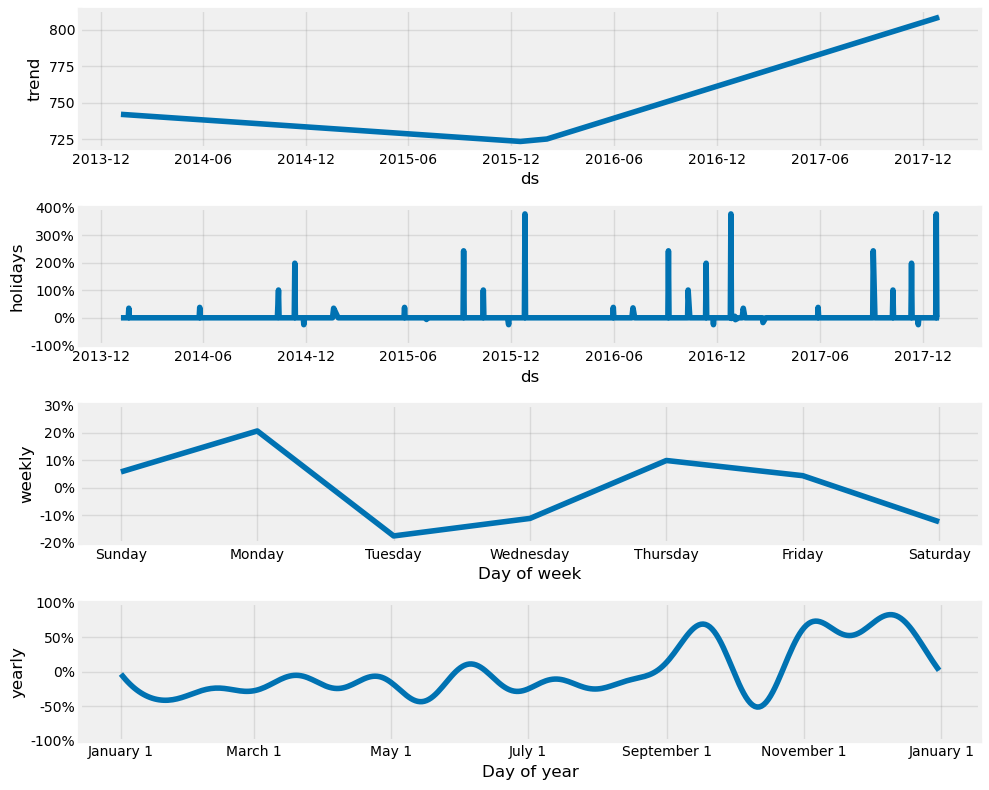

In [60]:
# Inspecting model components
future = m.make_future_dataframe(periods=92, freq='D')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2));

In [61]:
# Examining the point forecast and associated confidence bands
xfor = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].loc[forecast['ds'] >= '2017-10-01']
xfor.head(10)

ds         yhat   yhat_upper  yhat_lower
811 2017-10-01   821.029842  1992.593880 -338.155369
812 2017-10-02   878.848535  2092.648174 -273.897010
813 2017-10-03   516.372144  1623.419633 -619.758045
814 2017-10-04   512.361869  1604.205647 -707.327108
815 2017-10-05   629.972862  1850.725151 -550.754031
816 2017-10-06   541.224784  1713.292604 -699.938368
817 2017-10-07   369.115257  1580.232660 -795.915665
818 2017-10-08   482.344570  1680.181662 -650.234791
819 2017-10-09  1382.166025  2610.729020  283.872315
820 2017-10-10   257.153291  1450.910053 -949.939888

In [62]:
# Combining the forecast DF with the original test data for a visual check
xfor = pd.merge(xfor, df, on='ds', how='left')
xfor.head(10)

ds         yhat   yhat_upper  yhat_lower         y
0 2017-10-01   821.029842  1992.593880 -338.155369   559.760
1 2017-10-02   878.848535  2092.648174 -273.897010  2758.464
2 2017-10-03   516.372144  1623.419633 -619.758045   255.208
3 2017-10-04   512.361869  1604.205647 -707.327108    19.980
4 2017-10-05   629.972862  1850.725151 -550.754031   935.802
5 2017-10-06   541.224784  1713.292604 -699.938368    41.960
6 2017-10-07   369.115257  1580.232660 -795.915665   462.430
7 2017-10-08   482.344570  1680.181662 -650.234791   145.764
8 2017-10-09  1382.166025  2610.729020  283.872315  1333.393
9 2017-10-10   257.153291  1450.910053 -949.939888   239.358

<Axes: >

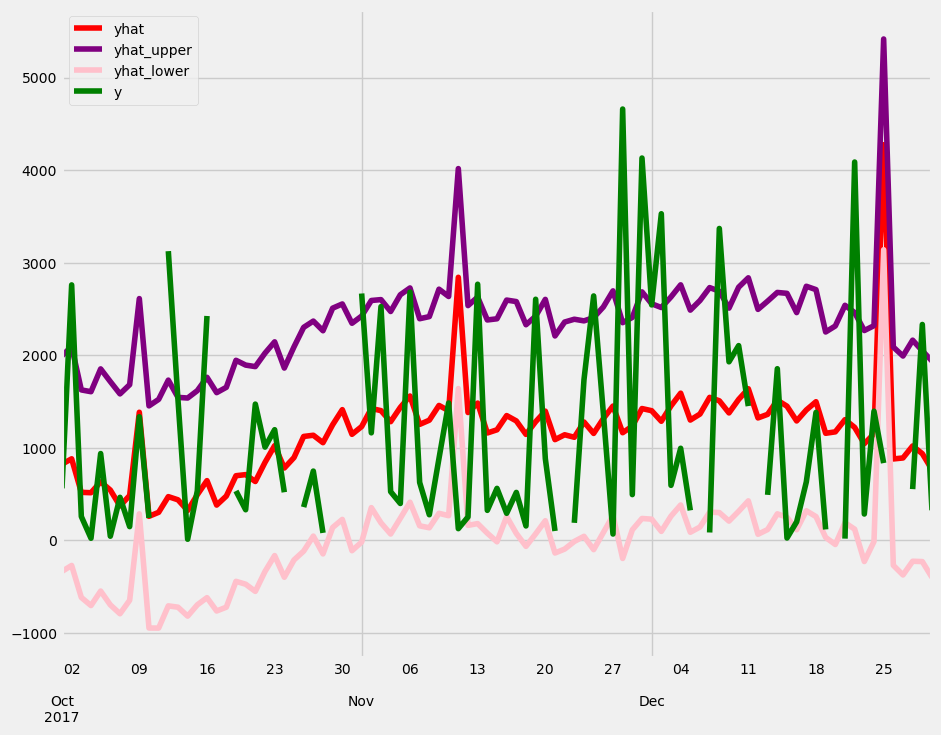

In [63]:
# Plotting for inspection
colors = ['red', 'purple', 'pink', 'green']
xfor['ds'] = pd.to_datetime(xfor['ds'])
xfor.set_index('ds').plot(color=colors, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel='')

The result definitely needs tuning given that the magnitude of the variations aren't being captured. But the interpretability of Prophet can help us improve quite rapidly.

## Using Covariates with Prophet

Using carefully thought out domain specific covariate data points, such as forward looking economic indicators, credit yields etc. can help in improving the model's performance.

In [109]:
# Download additional datasets from Konrad's NB
# This time we will be using the Autonomous Greenhouse Challenge data to predict air temperature
#dataset = "konradb/greenhouse-dataset"
#download_path = "data/greenhouse-dataset"

#download_data(dataset, download_path)

In [110]:
xdat = pd.read_csv('data/greenhouse-dataset/GreenhouseClimate1.csv', low_memory=False)

In [111]:
# Timestamp epoch needs to be adjusted
xdat['time'] = pd.to_datetime(xdat['time'], unit='D', origin="1899-12-30")
xdat.head()

time  AssimLight   BlackScr  CO2air  Cum_irr  \
0 2019-12-16 00:00:00.000000000         0.0  35.000000   439.0     0.48   
1 2019-12-16 00:04:59.808000285         0.0  85.000001   459.0     0.72   
2 2019-12-16 00:09:59.615999939         0.0  95.999999   461.0     0.72   
3 2019-12-16 00:15:00.287999887         0.0  92.000000   465.0     0.72   
4 2019-12-16 00:20:00.096000172         0.0  92.000000   467.0     0.72   

   EC_drain_PC  EnScr  HumDef  PipeGrow  PipeLow  ...  t_rail_min_sp  \
0         3.61   96.0    6.96       0.0     50.9  ...            NaN   
1         3.61   96.0    7.45       0.0     49.3  ...            NaN   
2         3.61   94.6    5.99       0.0     47.6  ...            NaN   
3         3.61   94.6    6.57       0.0     46.1  ...            NaN   
4         3.62   95.3    6.99       0.0     45.2  ...            NaN   

   t_rail_min_vip  t_vent_sp  t_ventlee_vip  t_ventwind_vip  water_sup  \
0             0.0        NaN           25.0            26.0        4.0   
1             0.0        NaN           25.0            26.0        6.0   
2             0.0        NaN           25.0            26.0        6.0   
3             0.0        NaN           25.0            26.0        6.0   
4             0.0        NaN           25.0            26.0        6.0   

   water_sup_intervals_sp_min  water_sup_intervals_vip_min  window_pos_lee_sp  \
0                         NaN                       1000.0                NaN   
1                         NaN                       1000.0                NaN   
2                         NaN                       1000.0                NaN   
3                         NaN                       1000.0                NaN   
4                         NaN                       1000.0                NaN   

   window_pos_lee_vip  
0                 1.2  
1                 1.2  
2                 1.2  
3                 1.2  
4                 1.2  

[5 rows x 50 columns]

In [112]:
# Timestamp and target variable based on Readme (stored in the DL folder)
list1 = ['time', 'Tair']

# Candidate variables for external regressors
list2 = ['co2_sp', 'dx_sp', 't_rail_min_sp', 't_grow_min_sp',
        'assim_sp', 'scr_enrg_sp', 'scr_blck_sp', 't_heat_sp',
        't_vent_sp', 'window_pos_lee_sp', 'water_sup_intervals_sp_min',
        'int_blue_sp', 'int_red_sp', 'int_farred_sp',
        'int_white_sp']

xdat = xdat[list1 + list2]

In [113]:
xdat.head(10)

time  Tair  co2_sp  dx_sp  t_rail_min_sp  \
0 2019-12-16 00:00:00.000000000  21.2     NaN    NaN            NaN   
1 2019-12-16 00:04:59.808000285  21.8     NaN    NaN            NaN   
2 2019-12-16 00:09:59.615999939  21.3     NaN    NaN            NaN   
3 2019-12-16 00:15:00.287999887  21.8     NaN    NaN            NaN   
4 2019-12-16 00:20:00.096000172  21.6     NaN    NaN            NaN   
5 2019-12-16 00:24:59.903999827  21.5     NaN    NaN            NaN   
6 2019-12-16 00:29:59.712000112  21.2     NaN    NaN            NaN   
7 2019-12-16 00:35:00.384000060  21.4     NaN    NaN            NaN   
8 2019-12-16 00:40:00.191999714  21.3     NaN    NaN            NaN   
9 2019-12-16 00:45:00.000000000  21.5     NaN    NaN            NaN   

   t_grow_min_sp  assim_sp  scr_enrg_sp  scr_blck_sp  t_heat_sp  t_vent_sp  \
0            NaN       NaN          NaN          NaN        NaN        NaN   
1            NaN       NaN          NaN          NaN        NaN        NaN   
2            NaN       NaN          NaN          NaN        NaN        NaN   
3            NaN       NaN          NaN          NaN        NaN        NaN   
4            NaN       NaN          NaN          NaN        NaN        NaN   
5            NaN       NaN          NaN          NaN        NaN        NaN   
6            NaN       NaN          NaN          NaN        NaN        NaN   
7            NaN       NaN          NaN          NaN        NaN        NaN   
8            NaN       NaN          NaN          NaN        NaN        NaN   
9            NaN       NaN          NaN          NaN        NaN        NaN   

   window_pos_lee_sp  water_sup_intervals_sp_min  int_blue_sp  int_red_sp  \
0                NaN                         NaN          NaN         NaN   
1                NaN                         NaN          0.0      1000.0   
2                NaN                         NaN          0.0      1000.0   
3                NaN                         NaN          0.0      1000.0   
4                NaN                         NaN          0.0      1000.0   
5                NaN                         NaN          0.0      1000.0   
6                NaN                         NaN          0.0      1000.0   
7                NaN                         NaN          0.0      1000.0   
8                NaN                         NaN          0.0      1000.0   
9                NaN                         NaN          0.0      1000.0   

   int_farred_sp  int_white_sp  
0            NaN           NaN  
1            0.0           0.0  
2            0.0           0.0  
3            0.0           0.0  
4            0.0           0.0  
5            0.0           0.0  
6            0.0           0.0  
7            0.0           0.0  
8            0.0           0.0  
9            0.0           0.0

In [115]:
# Converting to numeric
#to_num = [col for col in xdat.columns if col != 'time']
#xdat[to_num] =xdat[to_num].astype('float')
#xdat.info()

> A realistic lookahead period might be 24 hours - we can either stick to the original resolution of the data and forecast 24 * 12 = 288 steps ahead, or downsample the data to hourly frequency. Since all the variables are numerical, we just take their average values within each hour:


In [116]:
xdat2 = xdat.resample('H', on='time').mean().reset_index()[list1 + list2]
xdat2.head()

time       Tair  co2_sp  dx_sp  t_rail_min_sp  t_grow_min_sp  \
0 2019-12-16 00:00:00  21.391667     NaN    NaN            NaN            NaN   
1 2019-12-16 01:00:00  20.823077     NaN    NaN            NaN            NaN   
2 2019-12-16 02:00:00  21.100000     NaN    NaN            NaN            NaN   
3 2019-12-16 03:00:00  20.900000     NaN    NaN            NaN            NaN   
4 2019-12-16 04:00:00  20.976923     NaN    NaN            NaN            NaN   

   assim_sp  scr_enrg_sp  scr_blck_sp  t_heat_sp  t_vent_sp  \
0       NaN          NaN          NaN        NaN        NaN   
1       NaN          NaN          NaN        NaN        NaN   
2       NaN          NaN          NaN        NaN        NaN   
3       NaN          NaN          NaN        NaN        NaN   
4       NaN          NaN          NaN        NaN        NaN   

   window_pos_lee_sp  water_sup_intervals_sp_min  int_blue_sp  int_red_sp  \
0                NaN                         NaN          0.0      1000.0   
1                NaN                         NaN          0.0      1000.0   
2                NaN                         NaN          0.0      1000.0   
3                NaN                         NaN          0.0      1000.0   
4                NaN                         NaN          0.0      1000.0   

   int_farred_sp  int_white_sp  
0            0.0           0.0  
1            0.0           0.0  
2            0.0           0.0  
3            0.0           0.0  
4            0.0           0.0

In [117]:
# Checking for missing values
np.isnan(xdat2[['Tair'] + list2]).describe()

Tair co2_sp  dx_sp t_rail_min_sp t_grow_min_sp assim_sp scr_enrg_sp  \
count    3985   3985   3985          3985          3985     3985        3985   
unique      2      2      2             2             2        2           2   
top     False  False  False         False         False    False       False   
freq     3983   3945   3944          3944          3878     3944        3944   

       scr_blck_sp t_heat_sp t_vent_sp window_pos_lee_sp  \
count         3985      3985      3985              3985   
unique           2         2         2                 2   
top          False     False     False             False   
freq          3944      3945      3945              3944   

       water_sup_intervals_sp_min int_blue_sp int_red_sp int_farred_sp  \
count                        3985        3985       3985          3985   
unique                          2           1          1             1   
top                         False       False      False         False   
freq                         3901        3985       3985          3985   

       int_white_sp  
count          3985  
unique            1  
top           False  
freq           3985

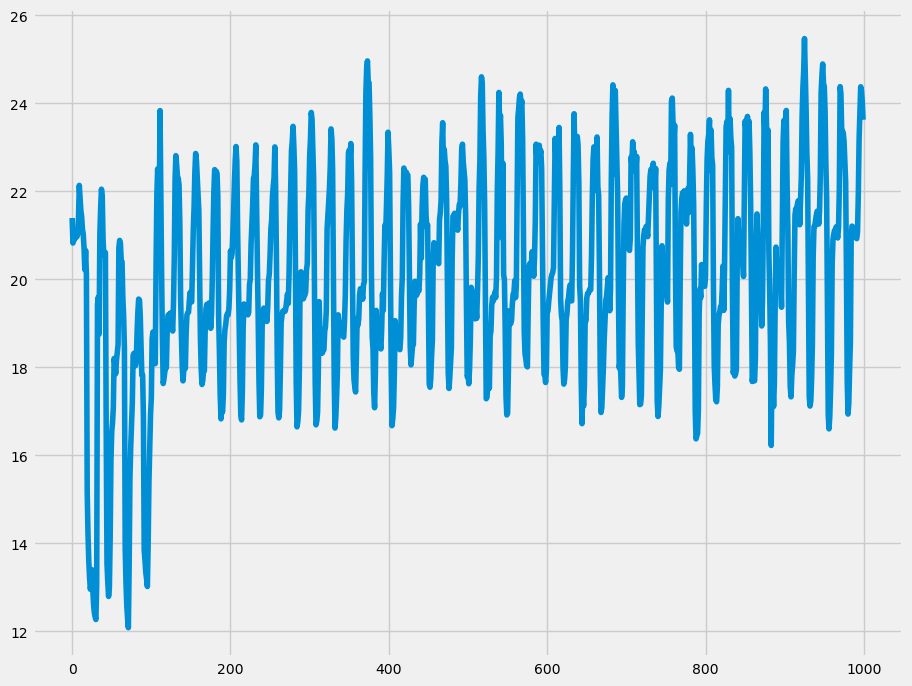

In [119]:
# Dropping nulls
xdat2.dropna(subset = ['Tair'], inplace=True)

# Plotting
xdat2['Tair'][0:1000].plot();


In [120]:
# Prepping columns 
df = xdat2[['time', 'Tair']].rename(columns={"time": "ds", "Tair": "y"})

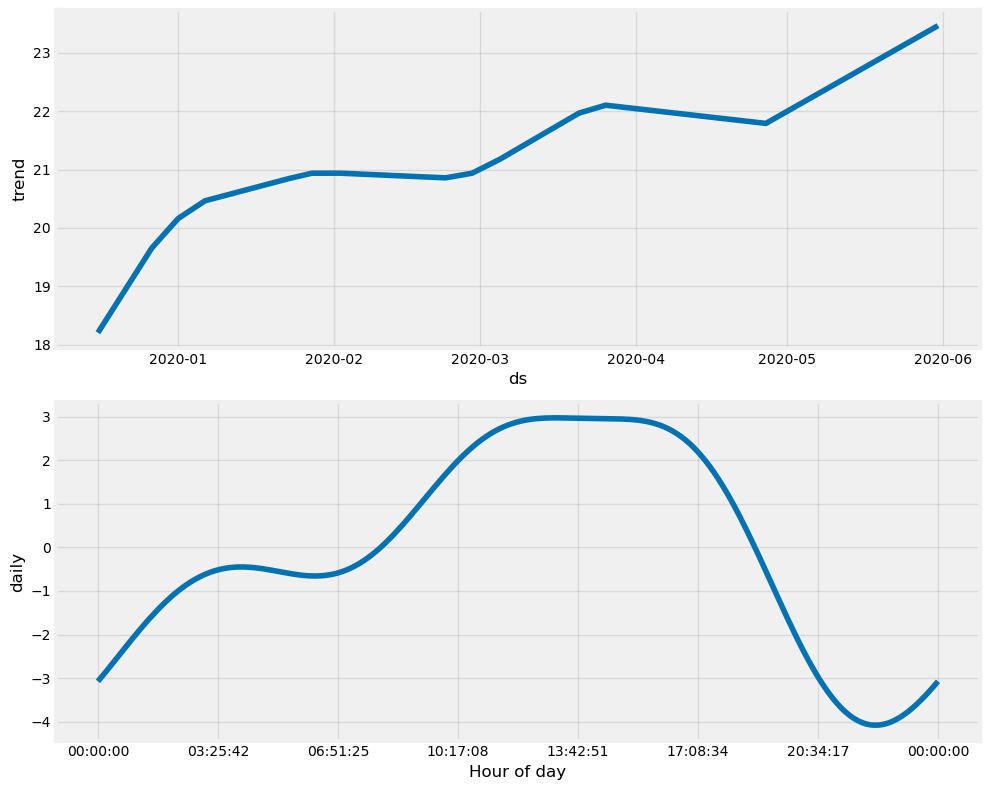

In [121]:
# Fitting while removing weekly seasonality, also we only have 6 months of data
# so that means annual is out as well
m = Prophet(weekly_seasonality=False, interval_width=0.95)
m.fit(df)

future = m.make_future_dataframe(periods=24, freq='H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2));

In [125]:
# Cross validation performance on baseline model
df_cv = cross_validation(m, initial='3700 hours', period='24 hours', horizon='24 hours')
df_p1 = performance_metrics(df_cv)
df_p1.head(10)

  0%|          | 0/11 [00:00<?, ?it/s]

horizon       mse      rmse       mae      mape     mdape     smape  \
0 0 days 03:00:00  4.349716  2.085597  1.872469  0.097083  0.097930  0.092216   
1 0 days 04:00:00  5.206981  2.281881  2.072851  0.105343  0.101739  0.099355   
2 0 days 05:00:00  5.915392  2.432158  2.220750  0.111538  0.114968  0.104718   
3 0 days 06:00:00  6.267040  2.503406  2.294276  0.114954  0.115212  0.107734   
4 0 days 07:00:00  5.451633  2.334873  2.123355  0.105610  0.115587  0.099484   
5 0 days 08:00:00  3.125345  1.767865  1.480062  0.071415  0.052698  0.068526   
6 0 days 09:00:00  1.798139  1.340947  1.078702  0.047763  0.038852  0.047904   
7 0 days 10:00:00  2.153520  1.467488  1.202652  0.048842  0.042226  0.050549   
8 0 days 11:00:00  2.987005  1.728295  1.459745  0.057717  0.045452  0.059462   
9 0 days 12:00:00  3.519202  1.875954  1.532759  0.060258  0.050560  0.061175   

   coverage  
0  0.846154  
1  0.818182  
2  0.779720  
3  0.741259  
4  0.765734  
5  0.881119  
6  0.972028  
7  0.961538  
8  0.923077  
9  0.870629

In [130]:
# Moving to the addition of covariates.
# While prophet can handle nulls in the target variable, the opposite is true for explanatory variables
xdat2 = xdat2.dropna()

# For simplicity Ridge() regression will be used to check for the variable importance
estimator = Ridge()
# RFECV - is basic and overly aggresive.
selector = RFECV(estimator, step=10, cv=10)
selector = selector.fit(xdat2[list2], xdat2['Tair'])

to_keep = xdat2[list2].columns[selector.support_]
print(to_keep)

Index(['dx_sp', 't_rail_min_sp', 't_heat_sp', 't_vent_sp',
       'window_pos_lee_sp'],
      dtype='object')


In [132]:
# Fitting the model with additional regressors
df = xdat2[['time', 'Tair']].rename(columns={"time": "ds", "Tair": "y"})
m = Prophet(weekly_seasonality=False, interval_width=0.95)

# Add regressors
for f in to_keep:
    df[f] = xdat2[f]
    m.add_regressor(f)

m.fit(df)

In [133]:
# Cross val
df_cv = cross_validation(m, initial = '3700 hours', period = '24 hours', horizon='24 hours')
df_p2 = performance_metrics(df_cv)
df_p2.head(10)

  0%|          | 0/7 [00:00<?, ?it/s]

horizon       mse      rmse       mae      mape     mdape     smape  \
0 0 days 03:00:00  1.894571  1.376434  1.012700  0.054299  0.028446  0.051896   
1 0 days 04:00:00  2.378020  1.542083  1.125712  0.059018  0.022076  0.055932   
2 0 days 05:00:00  2.602124  1.613110  1.246066  0.064388  0.065337  0.061067   
3 0 days 06:00:00  2.573021  1.604064  1.281481  0.066033  0.038276  0.062755   
4 0 days 07:00:00  2.075566  1.440683  1.171902  0.059792  0.037516  0.057177   
5 0 days 08:00:00  0.998173  0.999086  0.701127  0.034982  0.022352  0.033800   
6 0 days 09:00:00  0.446929  0.668527  0.489166  0.021840  0.014549  0.021836   
7 0 days 10:00:00  0.489706  0.699790  0.583324  0.023836  0.020754  0.024220   
8 0 days 11:00:00  0.634635  0.796640  0.616067  0.025231  0.017643  0.025203   
9 0 days 12:00:00  0.992856  0.996422  0.647792  0.027420  0.013693  0.026627   

   coverage  
0  0.625000  
1  0.571429  
2  0.571429  
3  0.571429  
4  0.633929  
5  0.821429  
6  0.964286  
7  1.000000  
8  0.937500  
9  0.875000

In [134]:
# Directly comparing the models
comparison =  pd.DataFrame()
comparison['baseline'] = df_p1.mean(axis=0)[1:]
comparison['covariates'] = df_p2.mean(axis=0)[1:]

print(comparison)

          baseline covariates
mse       9.377217   1.102375
rmse      2.801777   0.989511
mae       2.339873   0.738402
mape      0.095258   0.033816
mdape     0.086199   0.023105
smape     0.098635    0.03312
coverage  0.713764   0.852679


Thus, adding the covariate regressors to this particular dataset definitely improves performance.